In [18]:
# -*- coding: utf-8 -*-
import sys

import numpy as np
from os import path
import matplotlib.pyplot as plt

# scikit-learn related imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim

# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import (
    IntegratedGradients,
    DeepLift,
    GradientShap,
    NoiseTunnel,
    FeatureAblation,
)

" https://captum.ai/tutorials/House_Prices_Regression_Interpret "

' https://captum.ai/tutorials/House_Prices_Regression_Interpret '

In [19]:
def read_hrrr_data():
    """
    Reads and concatenates parquet files containing forecast and error data for HRRR weather models
    for the years 2018 to 2022.

    Returns:
        pandas.DataFrame: of hrrr weather forecast information for each NYSM site.
    """

    years = ["2018", "2019", "2020", "2021", "2022"]
    savedir = "/home/aevans/nwp_bias/src/machine_learning/data/hrrr_data/ny/"

    # create empty lists to hold dataframes for each model
    hrrr_fcast_and_error = []

    # loop over years and read in parquet files for each model
    for year in years:
        for month in np.arange(1, 13):
            str_month = str(month).zfill(2)
            if (
                os.path.exists(
                    f"{savedir}HRRR_{year}_{str_month}_direct_compare_to_nysm_sites_mask_water.parquet"
                )
                == True
            ):
                hrrr_fcast_and_error.append(
                    pd.read_parquet(
                        f"{savedir}HRRR_{year}_{str_month}_direct_compare_to_nysm_sites_mask_water.parquet"
                    )
                )
            else:
                continue

    # concatenate dataframes for each model
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index().dropna()

    # return dataframes for each model
    return hrrr_fcast_and_error_df


def columns_drop(df):
    df = df.drop(
        columns=[
            "level_0",
            "index",
            "lead time",
            "lsm",
            "index_nysm",
            "station_nysm",
        ]
    )
    return df


def add_suffix(df, stations):
    cols = ["valid_time", "time"]
    df = df.rename(
        columns={c: c + f"_{stations[0]}" for c in df.columns if c not in cols}
    )
    return df


def load_nysm_data():
    # these parquet files are created by running "get_resampled_nysm_data.ipynb"
    nysm_path = "/home/aevans/nwp_bias/data/nysm/"

    nysm_1H = []
    for year in np.arange(2018, 2023):
        df = pd.read_parquet(f"{nysm_path}nysm_1H_obs_{year}.parquet")
        df.reset_index(inplace=True)
        nysm_1H.append(df)
    nysm_1H_obs = pd.concat(nysm_1H)
    nysm_1H_obs["snow_depth"] = nysm_1H_obs["snow_depth"].fillna(-999)
    nysm_1H_obs.dropna(inplace=True)
    return nysm_1H_obs


def remove_elements_from_batch(X, y, s):
    cond = np.where(s)
    return X[cond], y[cond], s[cond]


def nwp_error(target, station, df):
    vars_dict = {
        "t2m": "tair",
        "mslma": "pres",
    }
    nysm_var = vars_dict.get(target)

    df = df[df[target] > -999]

    df["target_error"] = df[f"{target}_{station}"] - df[f"{nysm_var}_{station}"]
    return df

In [20]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, num_layers):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers,
        )
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(
            self.num_layers, batch_size, self.hidden_units
        ).requires_grad_()
        c0 = torch.zeros(
            self.num_layers, batch_size, self.hidden_units
        ).requires_grad_()

        # peephole architecture

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(
            hn[0]
        ).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [21]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import os
import re
import emd
import statistics as st
from dateutil.parser import parse


def col_drop(df):
    df = df.drop(
        columns=[
            "flag",
            "station",
            "latitude",
            "longitude",
            "t2m",
            "sh2",
            "d2m",
            "r2",
            "u10",
            "v10",
            "tp",
            "mslma",
            "orog",
            "tcc",
            "asnow",
            "cape",
            "dswrf",
            "dlwrf",
            "gh",
            "u_total",
            "u_dir",
            "new_tp",
            "lat",
            "lon",
            "elev",
            "tair",
            "ta9m",
            "td",
            "relh",
            "srad",
            "pres",
            "mslp",
            "wspd_sonic",
            "wmax_sonic",
            "wdir_sonic",
            "precip_total",
            "snow_depth",
        ]
    )
    df = df[df.columns.drop(list(df.filter(regex="time")))]
    df = df[df.columns.drop(list(df.filter(regex="station")))]
    df = df[df.columns.drop(list(df.filter(regex="tair")))]
    df = df[df.columns.drop(list(df.filter(regex="ta9m")))]
    df = df[df.columns.drop(list(df.filter(regex="td")))]
    df = df[df.columns.drop(list(df.filter(regex="relh")))]
    df = df[df.columns.drop(list(df.filter(regex="srad")))]
    df = df[df.columns.drop(list(df.filter(regex="pres")))]
    df = df[df.columns.drop(list(df.filter(regex="wspd")))]
    df = df[df.columns.drop(list(df.filter(regex="wmax")))]
    df = df[df.columns.drop(list(df.filter(regex="wdir")))]
    df = df[df.columns.drop(list(df.filter(regex="precip_total")))]
    df = df[df.columns.drop(list(df.filter(regex="snow_depth")))]

    return df


def format_climate_df(data_path):
    """
    Formats a climate data file located at the specified `data_path` into a pandas DataFrame.

    Args:
        data_path (str): The file path for the climate data file.

    Returns:
        pandas.DataFrame: A DataFrame containing the climate data, with the first column renamed to "year".
    """
    raw_index = np.loadtxt(f"{data_path}")
    cl_index = pd.DataFrame(raw_index)
    cl_index = cl_index.rename(columns={0: "year"})
    return cl_index


def get_clim_indexes(df, valid_times):
    """
    Fetch climate indexes data and add corresponding index values to the input DataFrame.

    This function takes a DataFrame (`df`) containing weather data with a 'valid_time' column representing
    timestamps. It reads climate indexes data from text files in the specified directory and extracts index
    values corresponding to the month and year of each timestamp in the DataFrame. The extracted index values
    are then added to the DataFrame with new columns named after each index.

    Parameters:
    df (pandas.DataFrame): Input DataFrame containing weather data with a 'valid_time' column.

    Returns:
    pandas.DataFrame: The input DataFrame with additional columns for each climate index containing their values.
    """

    clim_df_path = "/home/aevans/nwp_bias/src/correlation/data/indexes/"
    directory = os.listdir(clim_df_path)
    df["valid_time"] = valid_times

    # Loop through each file in the specified directory
    for d in directory:
        if d.endswith(".txt"):
            # Read the climate index data from the file and format it into a DataFrame
            clim_df = format_climate_df(f"{clim_df_path}{d}")
            index_name = d.split(".")[0]

            clim_ind_ls = []
            for t, _ in enumerate(df["valid_time"]):
                time_obj = df["valid_time"].iloc[t]
                dt_object = parse(str(time_obj))
                year = dt_object.strftime("%Y")
                month = dt_object.strftime("%m")
                # Filter the climate DataFrame to get data for the specific year
                df1 = clim_df.loc[clim_df["year"] == int(year)]
                df1 = df1.drop(columns="year")
                row_list = df1.values
                keys = df1.keys()
                key_vals = keys.tolist()

                # Extract the index value corresponding to the month of the timestamp
                the_list = []
                for n, _ in enumerate(key_vals):
                    val1 = key_vals[n]
                    val2 = row_list[0, n]
                    tup = (val1, val2)
                    the_list.append(tup)
                for k, r in the_list:
                    if str(k).zfill(2) == month:
                        clim_ind_ls.append(r)

            # Add the climate index values as a new column in the DataFrame
            df[index_name] = clim_ind_ls

    df = df.drop(columns="valid_time")
    return df


def encode(data, col, max_val, valid_times):
    data["valid_time"] = valid_times
    data = data[data.columns.drop(list(data.filter(regex="day")))]
    data["day_of_year"] = data["valid_time"].dt.dayofyear
    data[col + "_sin"] = np.sin(2 * np.pi * data[col] / max_val).astype(float)
    data[col + "_cos"] = np.cos(2 * np.pi * data[col] / max_val)
    data = data.drop(columns=["valid_time", "day_of_year"]).astype(float)

    return data


def normalize_df(df, valid_times):
    print("init normalizer")
    df = col_drop(df)
    the_df = df.dropna()
    for k, r in the_df.items():
        if len(the_df[k].unique()) == 1:
            org_str = str(k)
            my_str = org_str[:-5]
            vals = the_df.filter(regex=my_str)
            vals = vals.loc[0].tolist()
            means = st.mean(vals)
            stdevs = st.pstdev(vals)
            the_df[k] = (the_df[k] - means) / stdevs

            the_df = the_df.fillna(0)
        if re.search(
            "t2m|u10|v10",
            k,
        ):
            ind_val = the_df.columns.get_loc(k)
            x = the_df[k]
            imf = emd.sift.sift(x)
            the_df = the_df.drop(columns=k)
            for i in range(imf.shape[1]):
                imf_ls = imf[:, i].tolist()
                # Inserting the column at the
                # beginning in the DataFrame
                my_loc = ind_val + i
                the_df.insert(loc=(my_loc), column=f"{k}_imf_{i}", value=imf_ls)
        else:
            continue

    for k, r in the_df.items():
        means = st.mean(the_df[k])
        stdevs = st.pstdev(the_df[k])
        the_df[k] = (the_df[k] - means) / stdevs

    final_df = the_df.fillna(0)
    print("!!! Dropping Columns !!!")
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="latitude")))]
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="longitude")))]
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="u_total")))]
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="mslp")))]
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="orog")))]

    print("--- configuring data ---")
    final_df = encode(final_df, "day_of_year", 366, valid_times)
    final_df = get_clim_indexes(final_df, valid_times)
    og_features = list(final_df.columns.difference(["target_error"]))
    new_features = og_features

    print("---normalize successful---")

    return final_df, new_features

In [22]:
# print("-- loading data from nysm --")
# # read in hrrr and nysm data
# nysm_df = load_nysm_data()
# nysm_df.reset_index(inplace=True)
# print("-- loading data from hrrr --")
# hrrr_df = read_hrrr_data()
# nysm_df = nysm_df.rename(columns={"time_1H": "valid_time"})
# mytimes = hrrr_df["valid_time"].tolist()
# nysm_df = nysm_df[nysm_df["valid_time"].isin(mytimes)]
# nysm_df.to_csv("/home/aevans/nwp_bias/src/machine_learning/frankenstein/test.csv")

# # tabular data paths
# nysm_cats_path = "/home/aevans/nwp_bias/src/landtype/data/nysm.csv"

# # tabular data dataframes
# print("-- adding geo data --")
# nysm_cats_df = pd.read_csv(nysm_cats_path)

# print("-- locating target data --")
# # partition out parquets by nysm climate division
# category = "Western Plateau"
# nysm_cats_df1 = nysm_cats_df[nysm_cats_df["climate_division_name"] == category]
# stations = nysm_cats_df1["stid"].tolist()
# hrrr_df1 = hrrr_df[hrrr_df["station"].isin(stations)]
# nysm_df1 = nysm_df[nysm_df["station"].isin(stations)]
# print("-- cleaning target data --")
# master_df = hrrr_df1.merge(nysm_df1, on="valid_time", suffixes=(None, "_nysm"))
# master_df = master_df.drop_duplicates(
#     subset=["valid_time", "station", "t2m"], keep="first"
# )
# print("-- finalizing dataframe --")
# df = columns_drop(master_df)
# stations = df["station"].unique()

# master_df = df[df["station"] == stations[0]]
# master_df = add_suffix(master_df, stations)

# for station in stations:
#     df1 = df[df["station"] == station]
#     master_df = master_df.merge(df1, on="valid_time", suffixes=(None, f"_{station}"))

# the_df = master_df.copy()

# the_df.dropna(inplace=True)
# print("getting flag and error")
# the_df = get_flag.get_flag(the_df)

# the_df = nwp_error("t2m", "OLEA", the_df)
# new_df = the_df.copy()

# print("Data Processed")
# print("--init model LSTM--")
# valid_times = new_df["valid_time"].tolist()
# # columns to reintigrate back into the df after model is done running
# cols_to_carry = ["valid_time", "flag"]

# # establish target
# target_sensor = "target_error"
# lstm_df, features = normalize_df(new_df, valid_times)
# forecast_lead = forecast_lead
# target = f"{target_sensor}_lead_{forecast_lead}"
# lstm_df[target] = lstm_df[target_sensor].shift(-forecast_lead)
# lstm_df = lstm_df.iloc[:-forecast_lead]

# # create train and test set
# length = len(lstm_df)
# test_len = int(length * 0.2)
# df_train = lstm_df.iloc[test_len:].copy()
# df_test = lstm_df.iloc[:test_len].copy()
# print("Test Set Fraction", len(df_test) / len(lstm_df))
# df_train = df_train.fillna(0)
# df_test = df_test.fillna(0)

# # bring back columns
# for c in cols_to_carry:
#     df_train[c] = the_df[c]
#     df_test[c] = the_df[c]

In [25]:
features = np.loadtxt(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231023/OLEA_loss_0.8970391166190339_20231023_15:56/OLEA_loss_0.8970391166190339.txt",
    dtype=str,
)

In [26]:
# load model
num_layers = 3
model = ShallowRegressionLSTM(
    num_sensors=len(features), hidden_units=len(features), num_layers=num_layers
)
model.load_state_dict(
    torch.load(
        "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231023/OLEA_loss_0.8970391166190339_20231023_15:56/OLEA_loss_0.8970391166190339.pth"
    )
)
model.eval()

ShallowRegressionLSTM(
  (lstm): LSTM(443, 443, num_layers=3, batch_first=True)
  (linear): Linear(in_features=443, out_features=1, bias=True)
)

In [27]:
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

(443,)


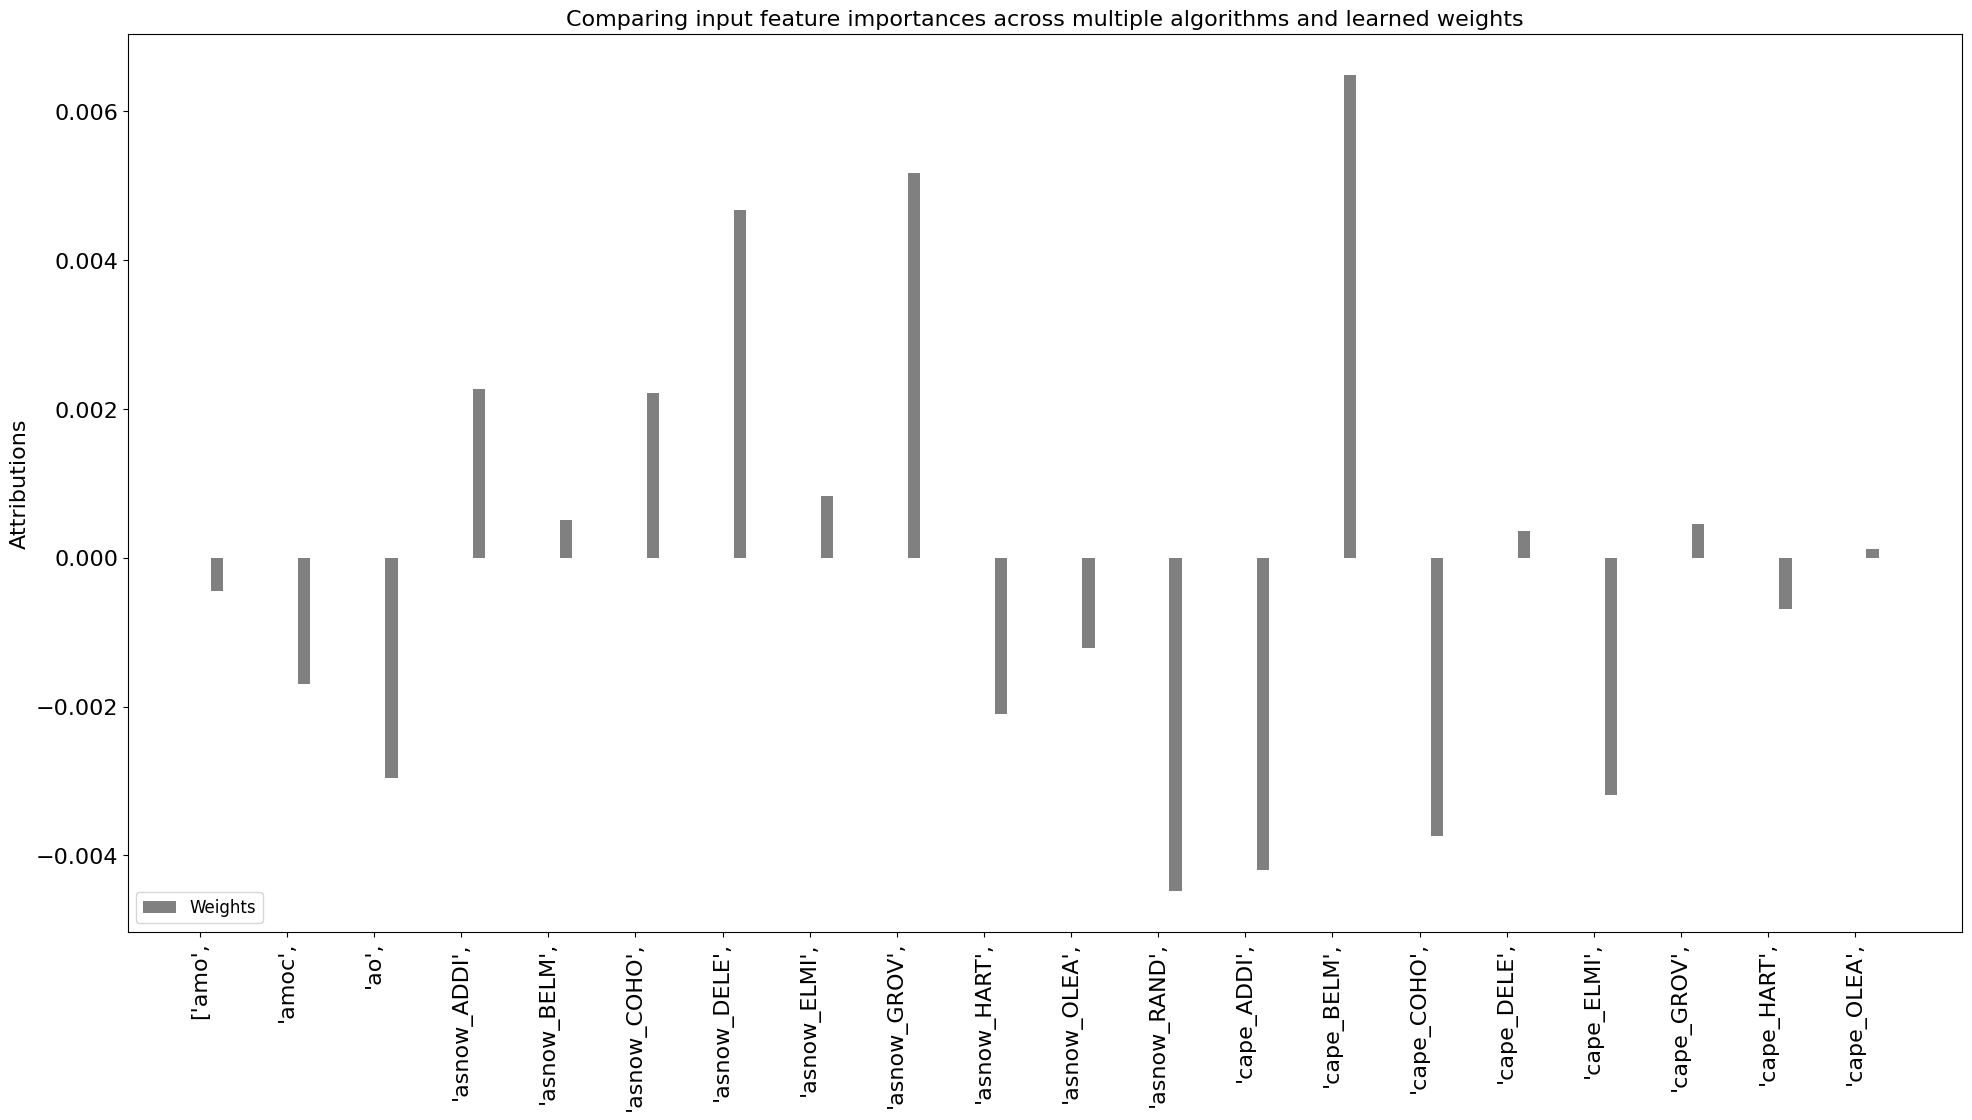

(443,)


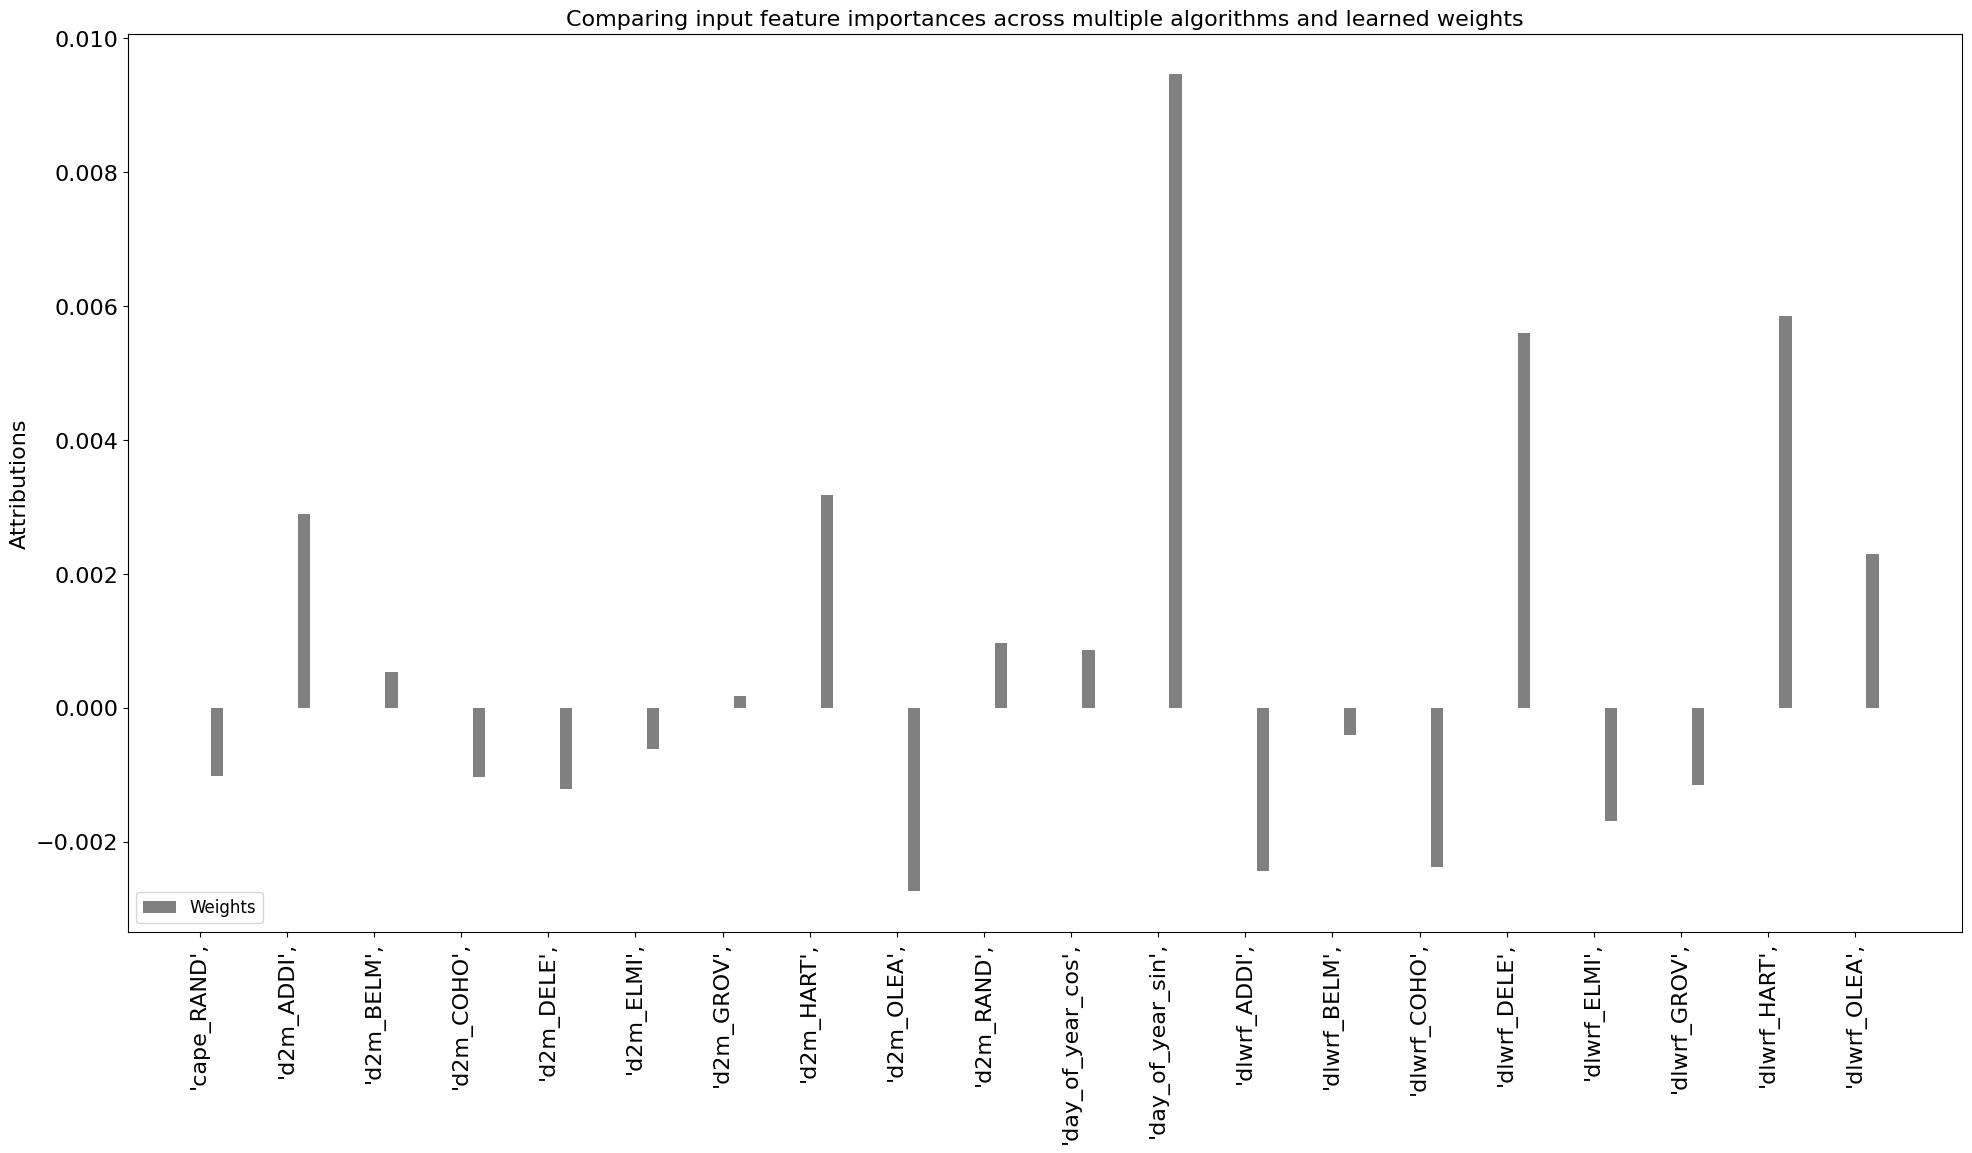

(443,)


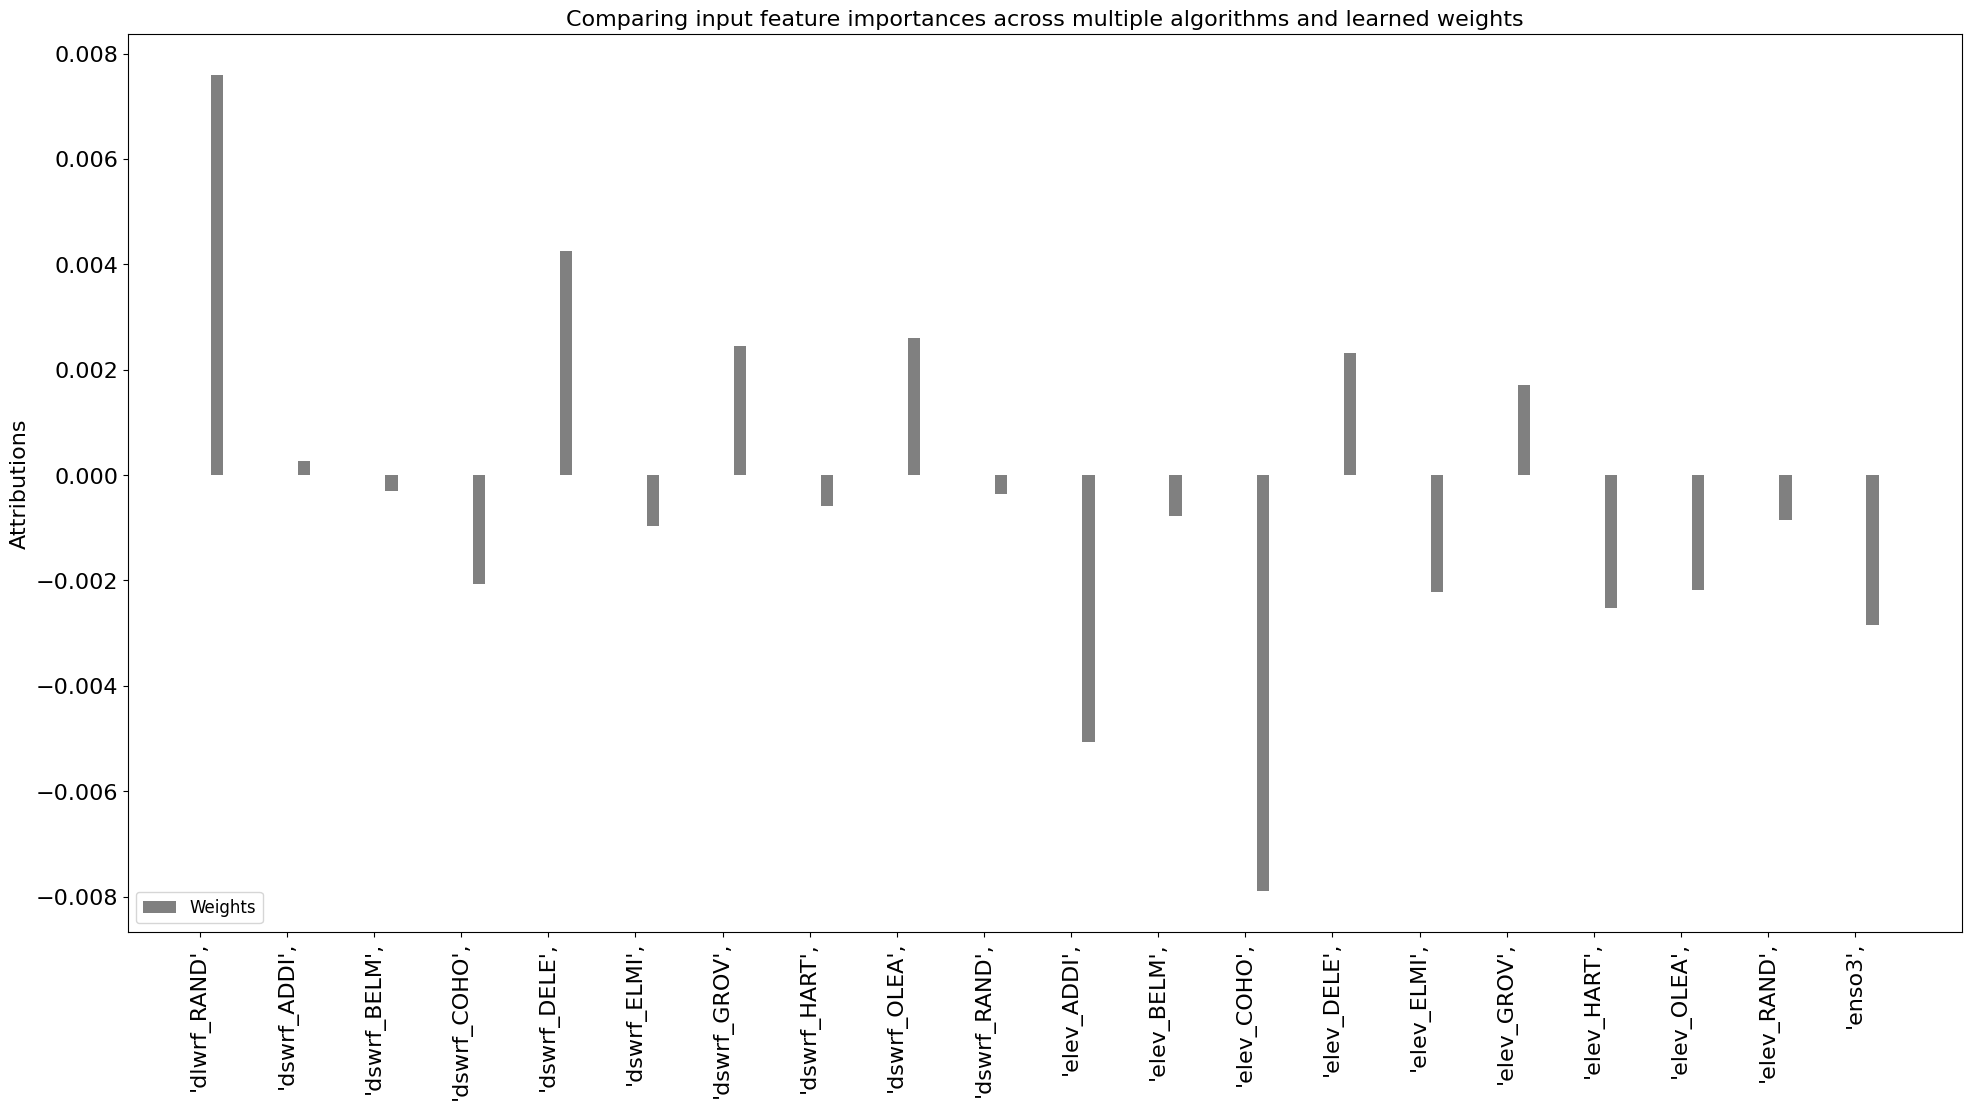

(443,)


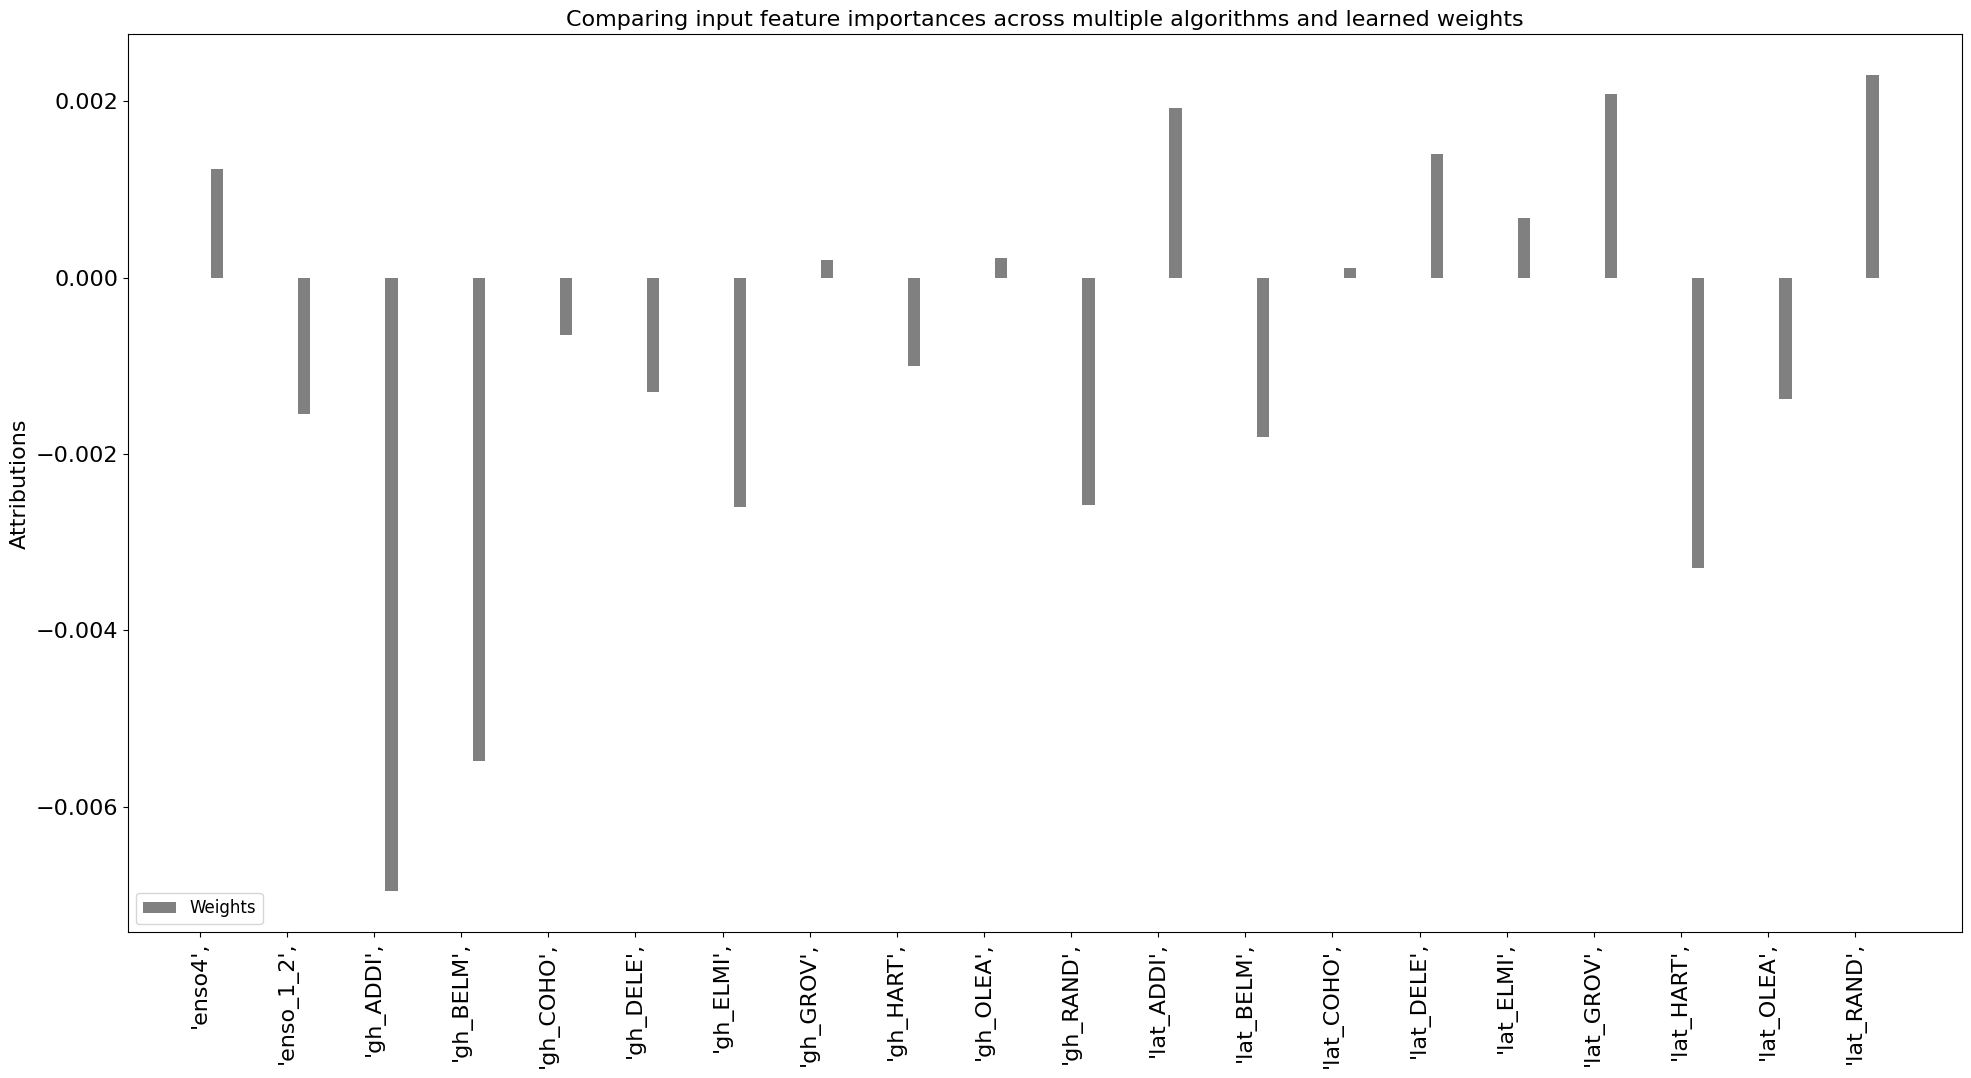

(443,)


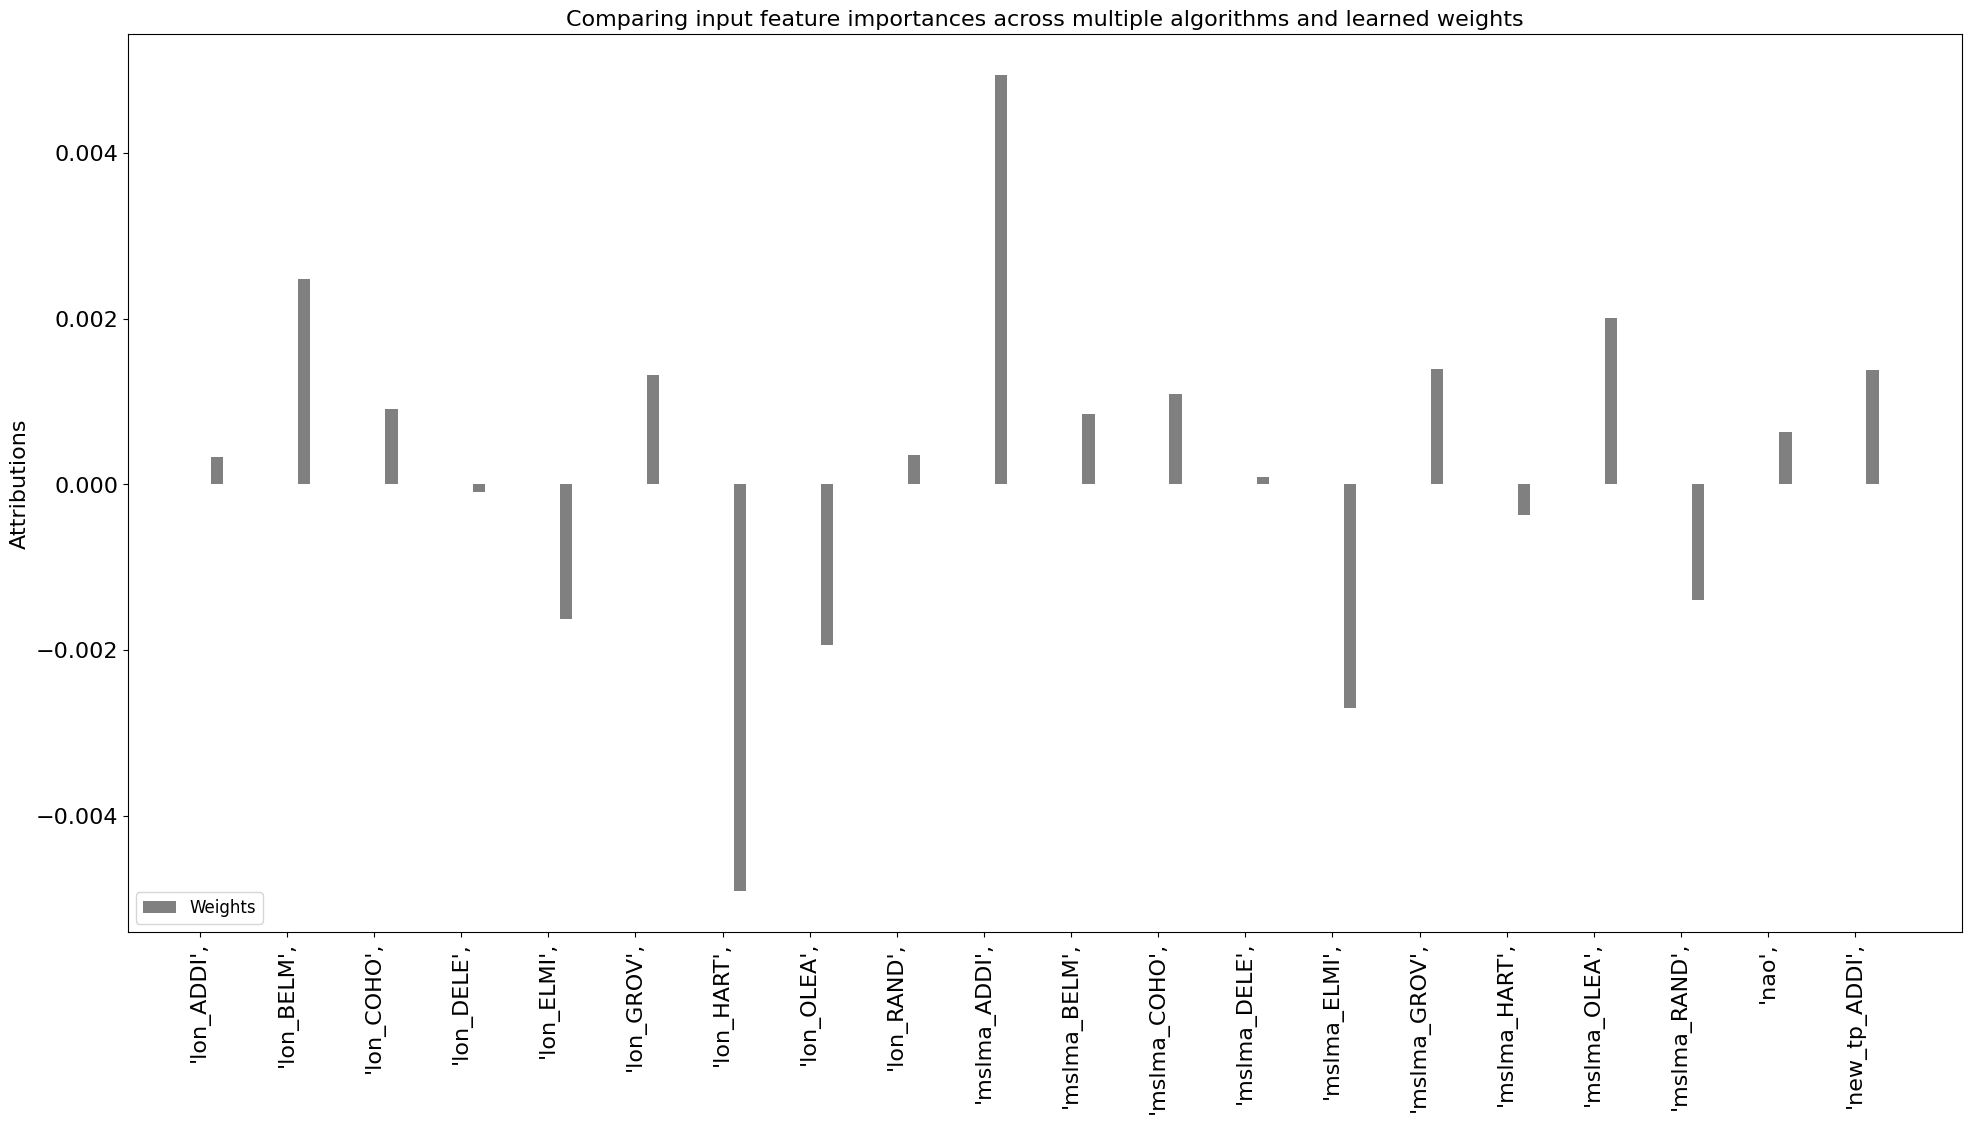

(443,)


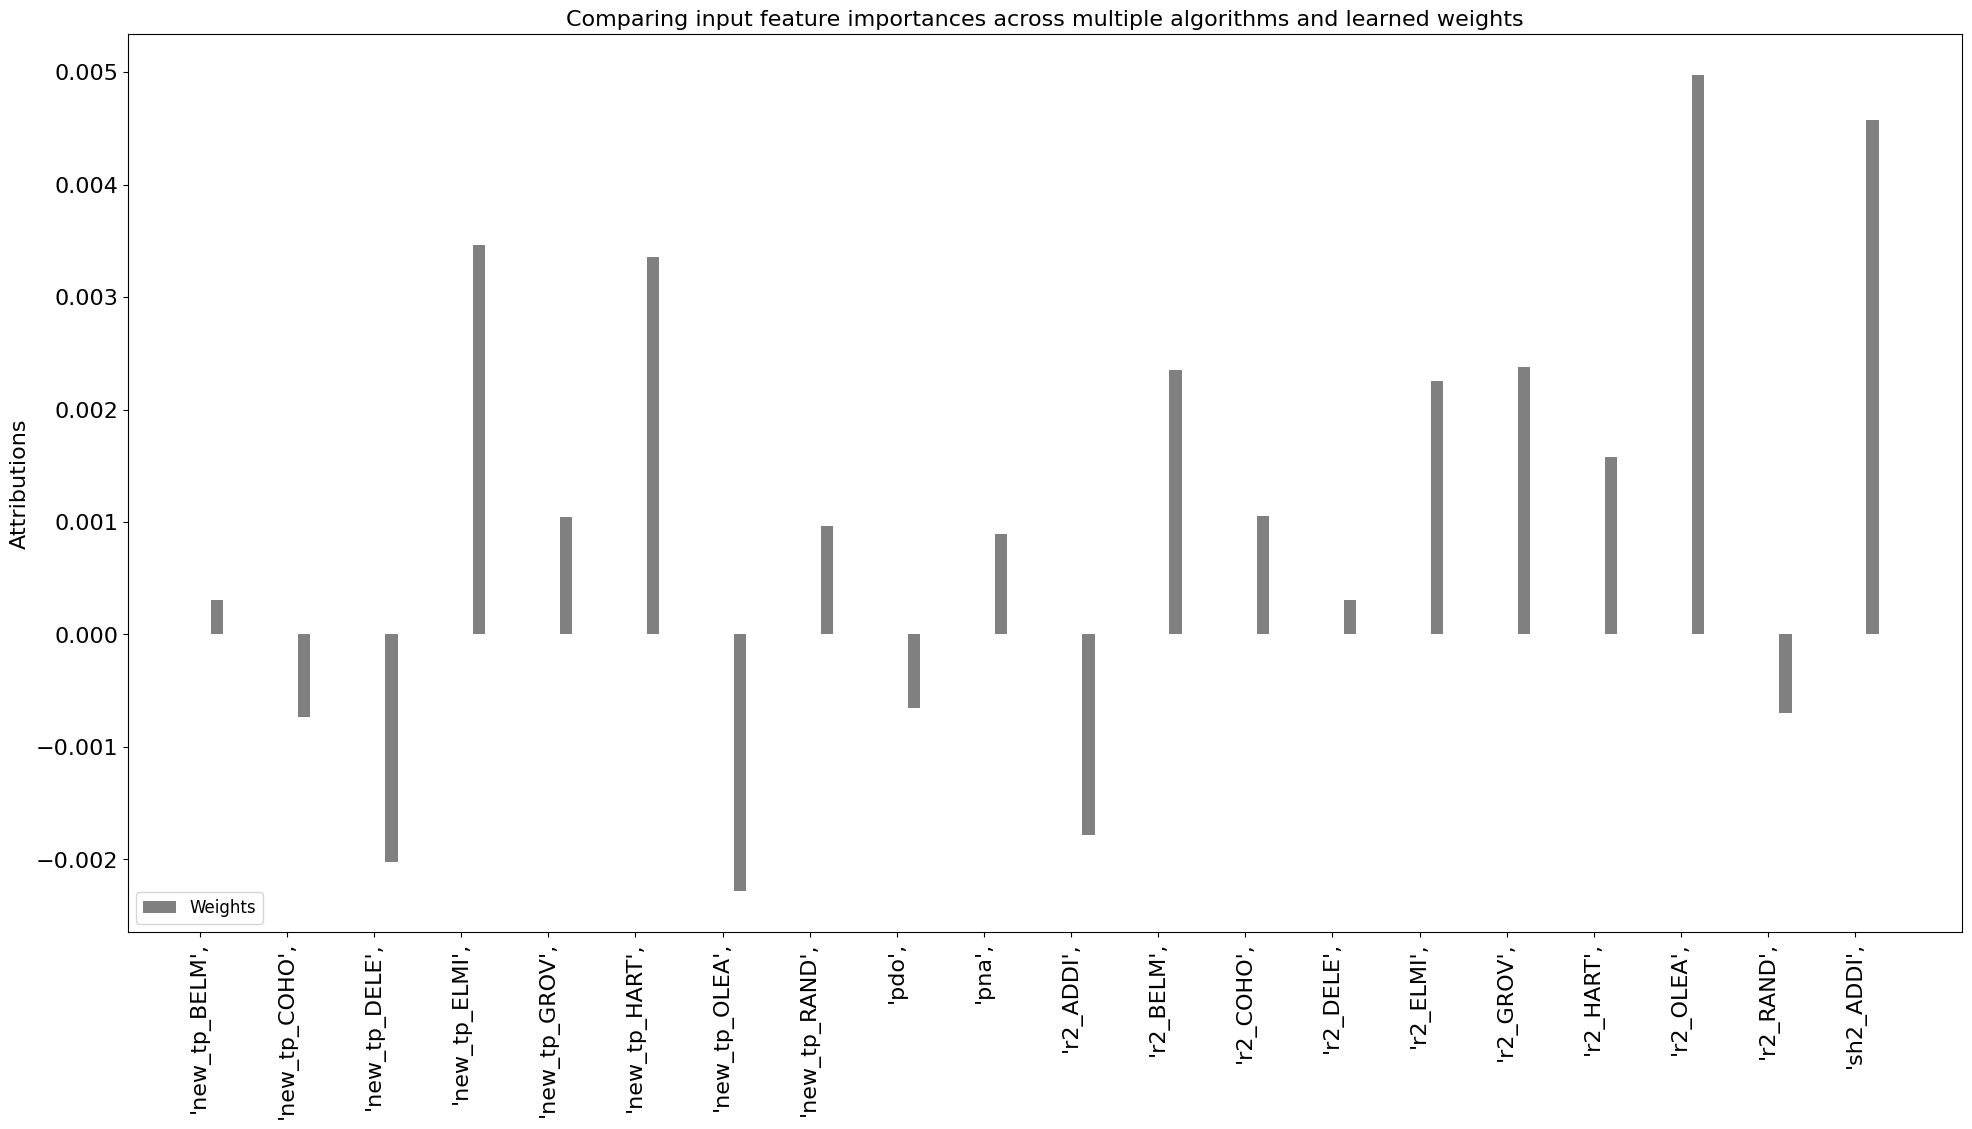

(443,)


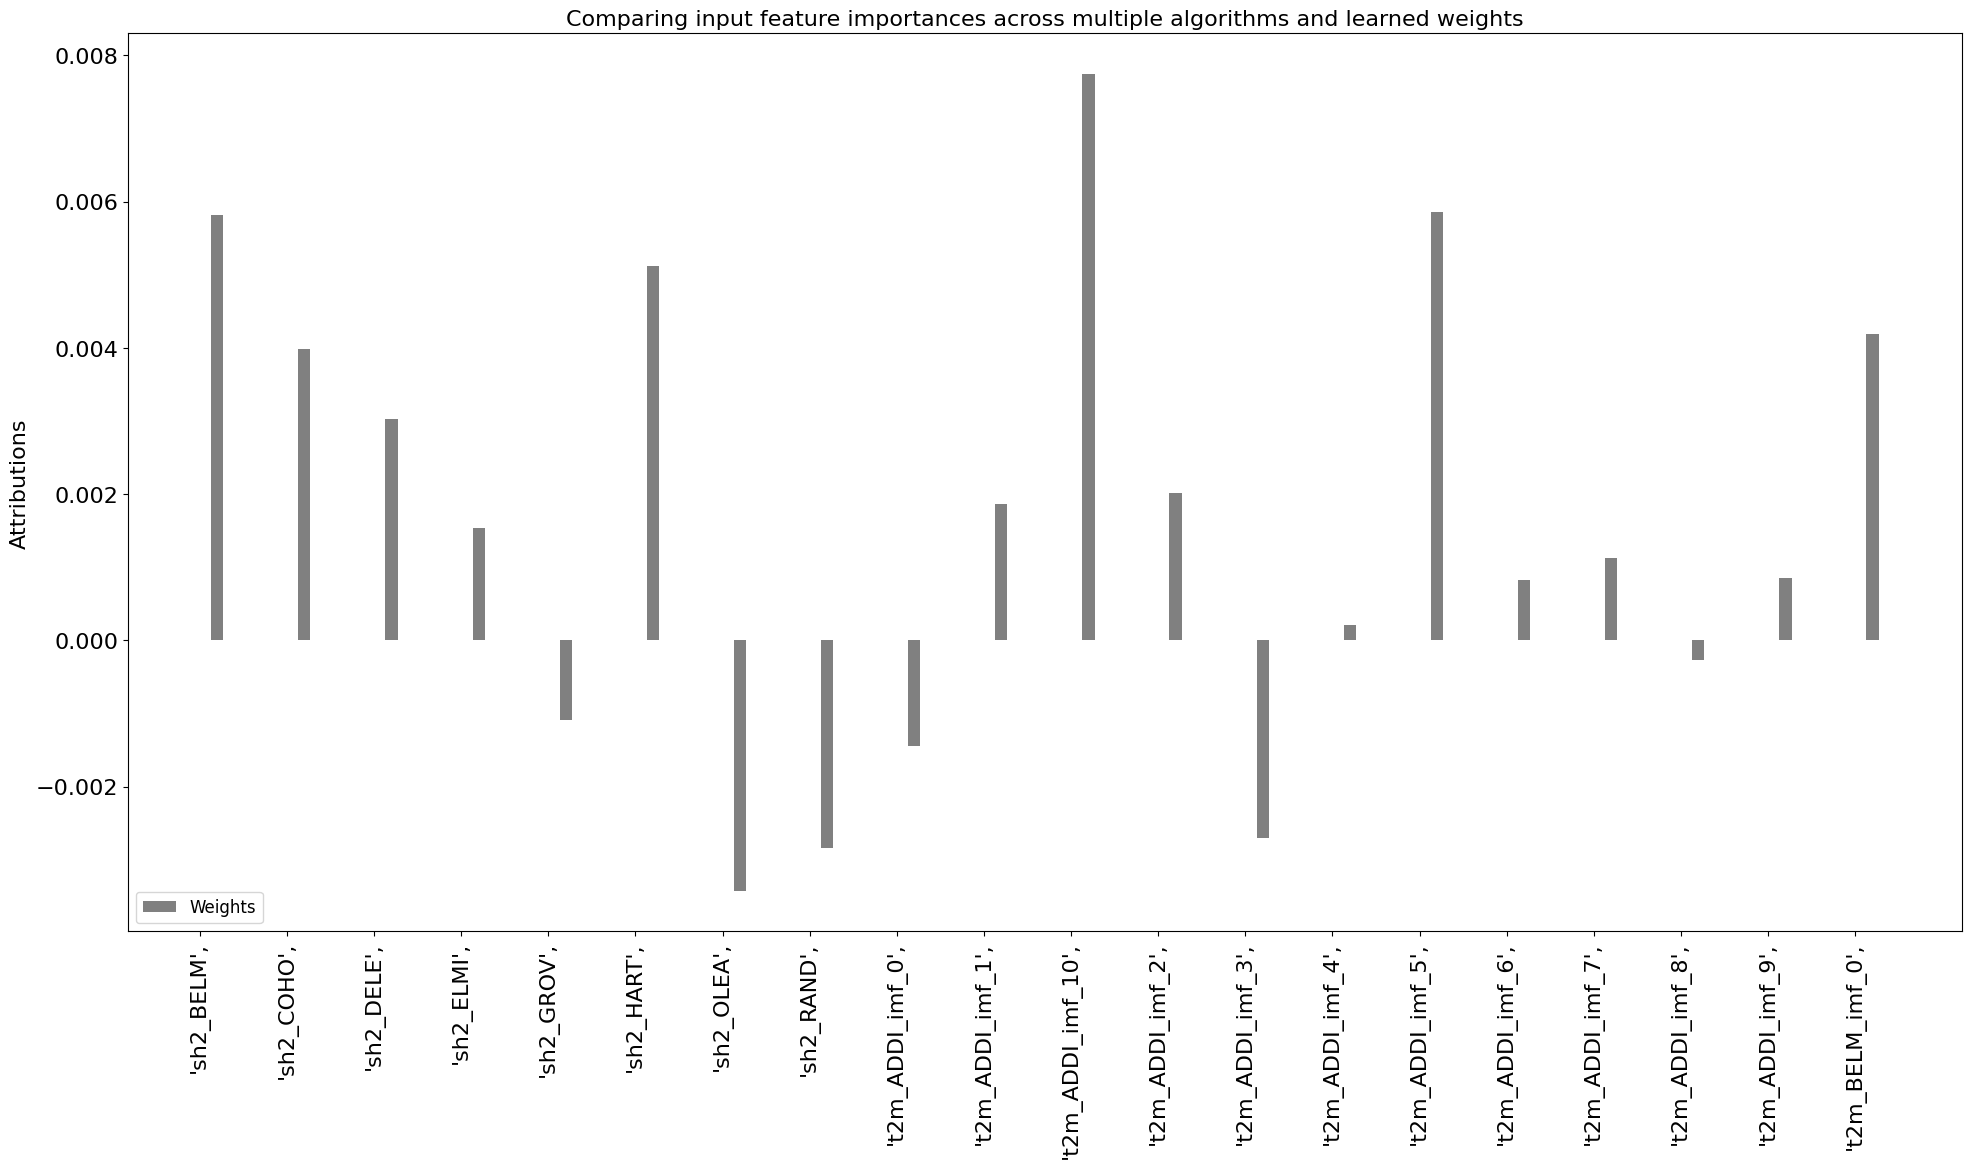

(443,)


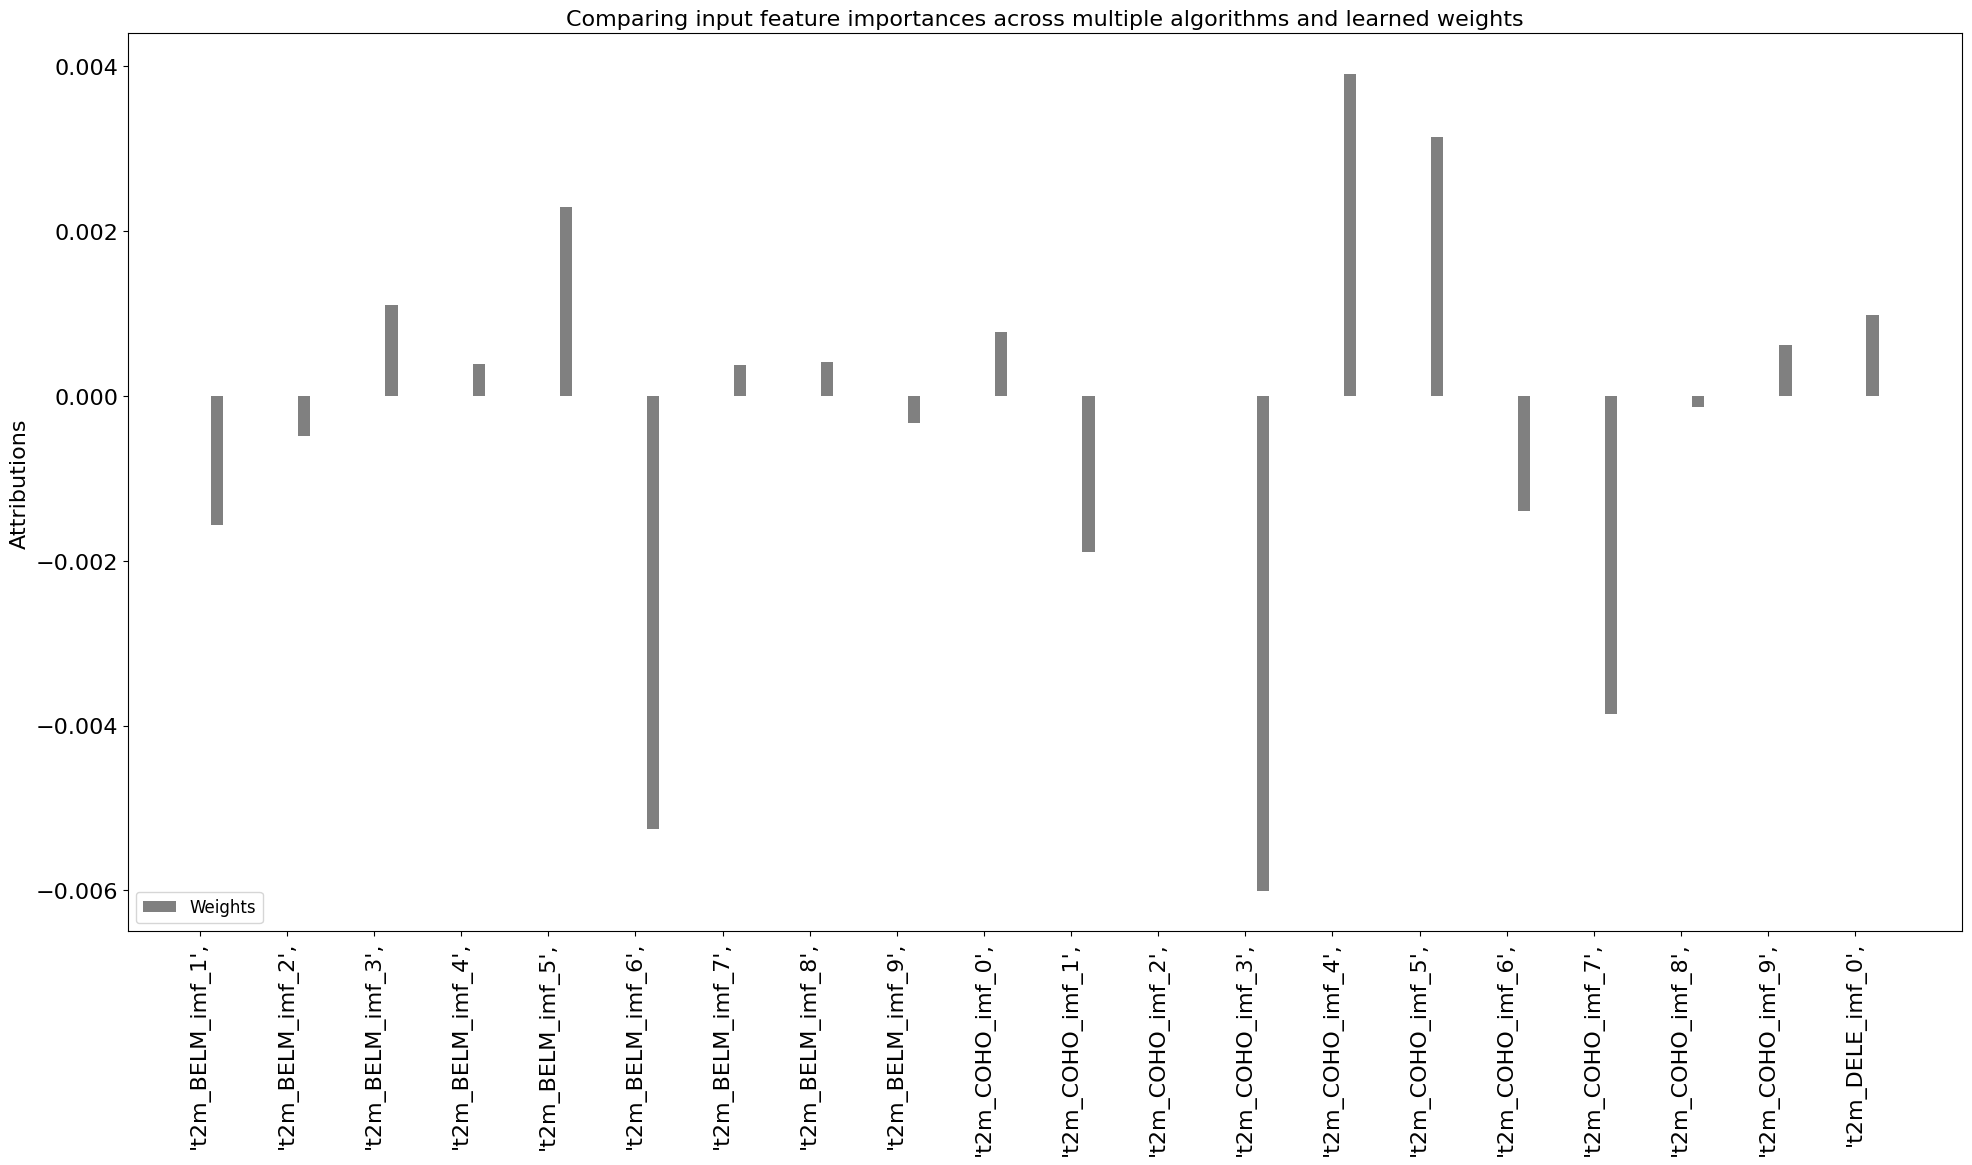

(443,)


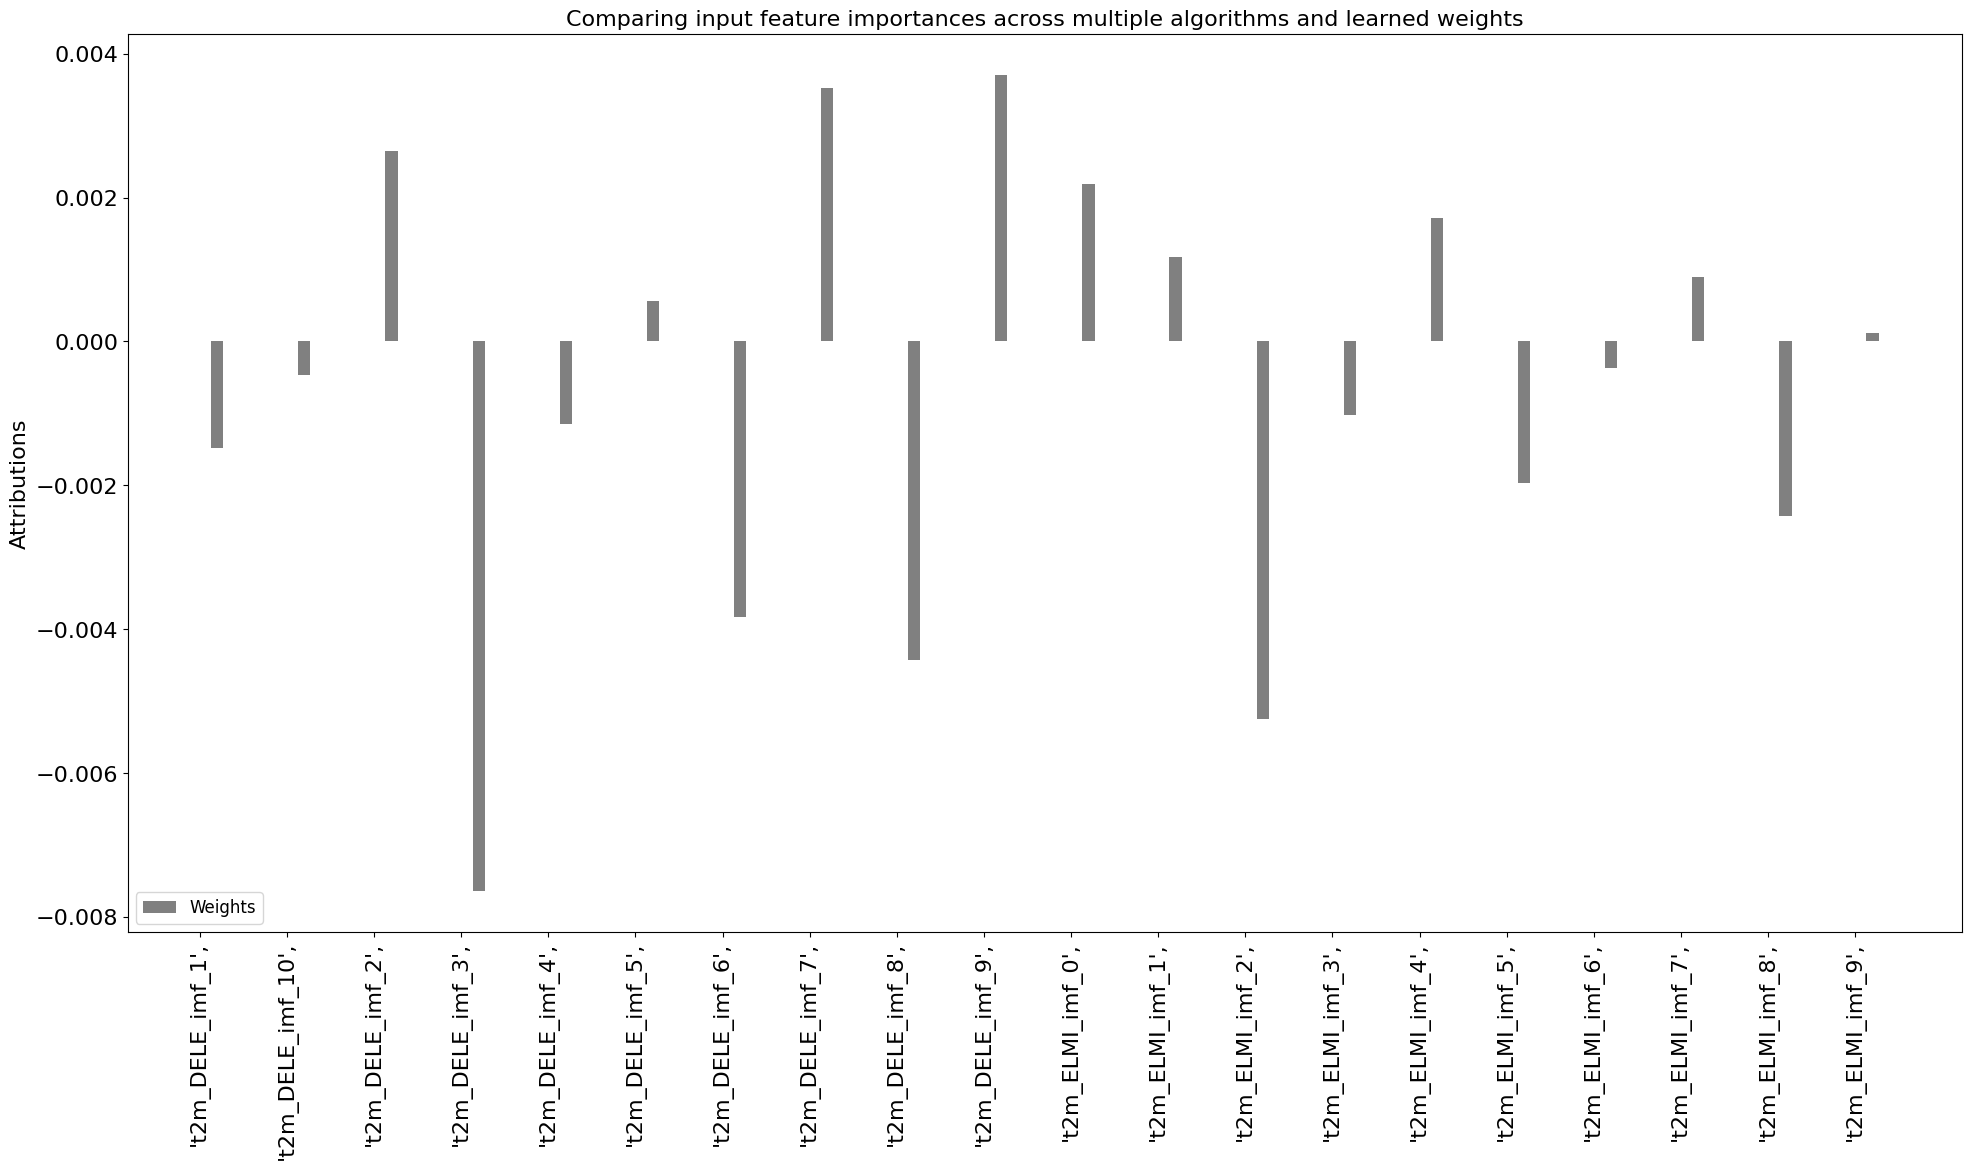

(443,)


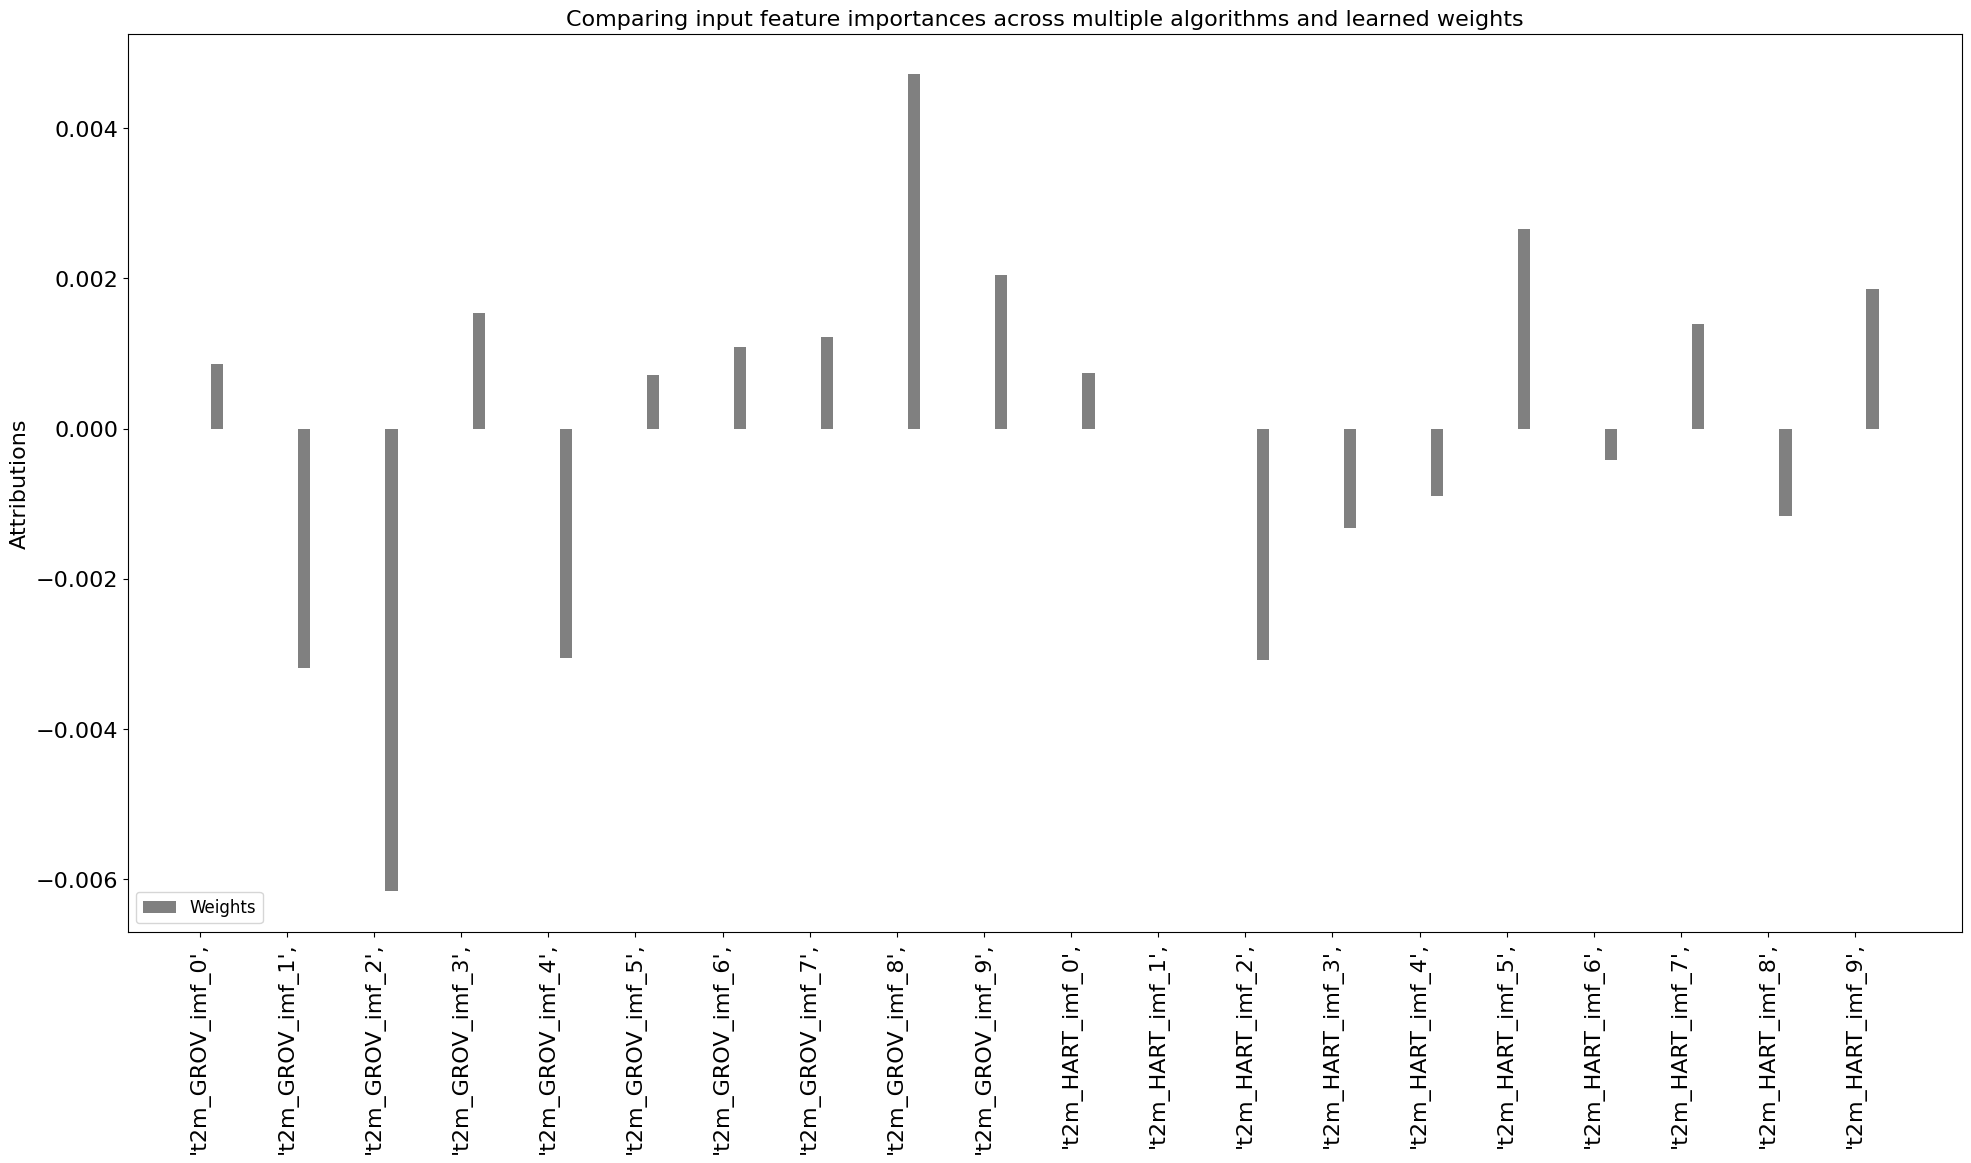

(443,)


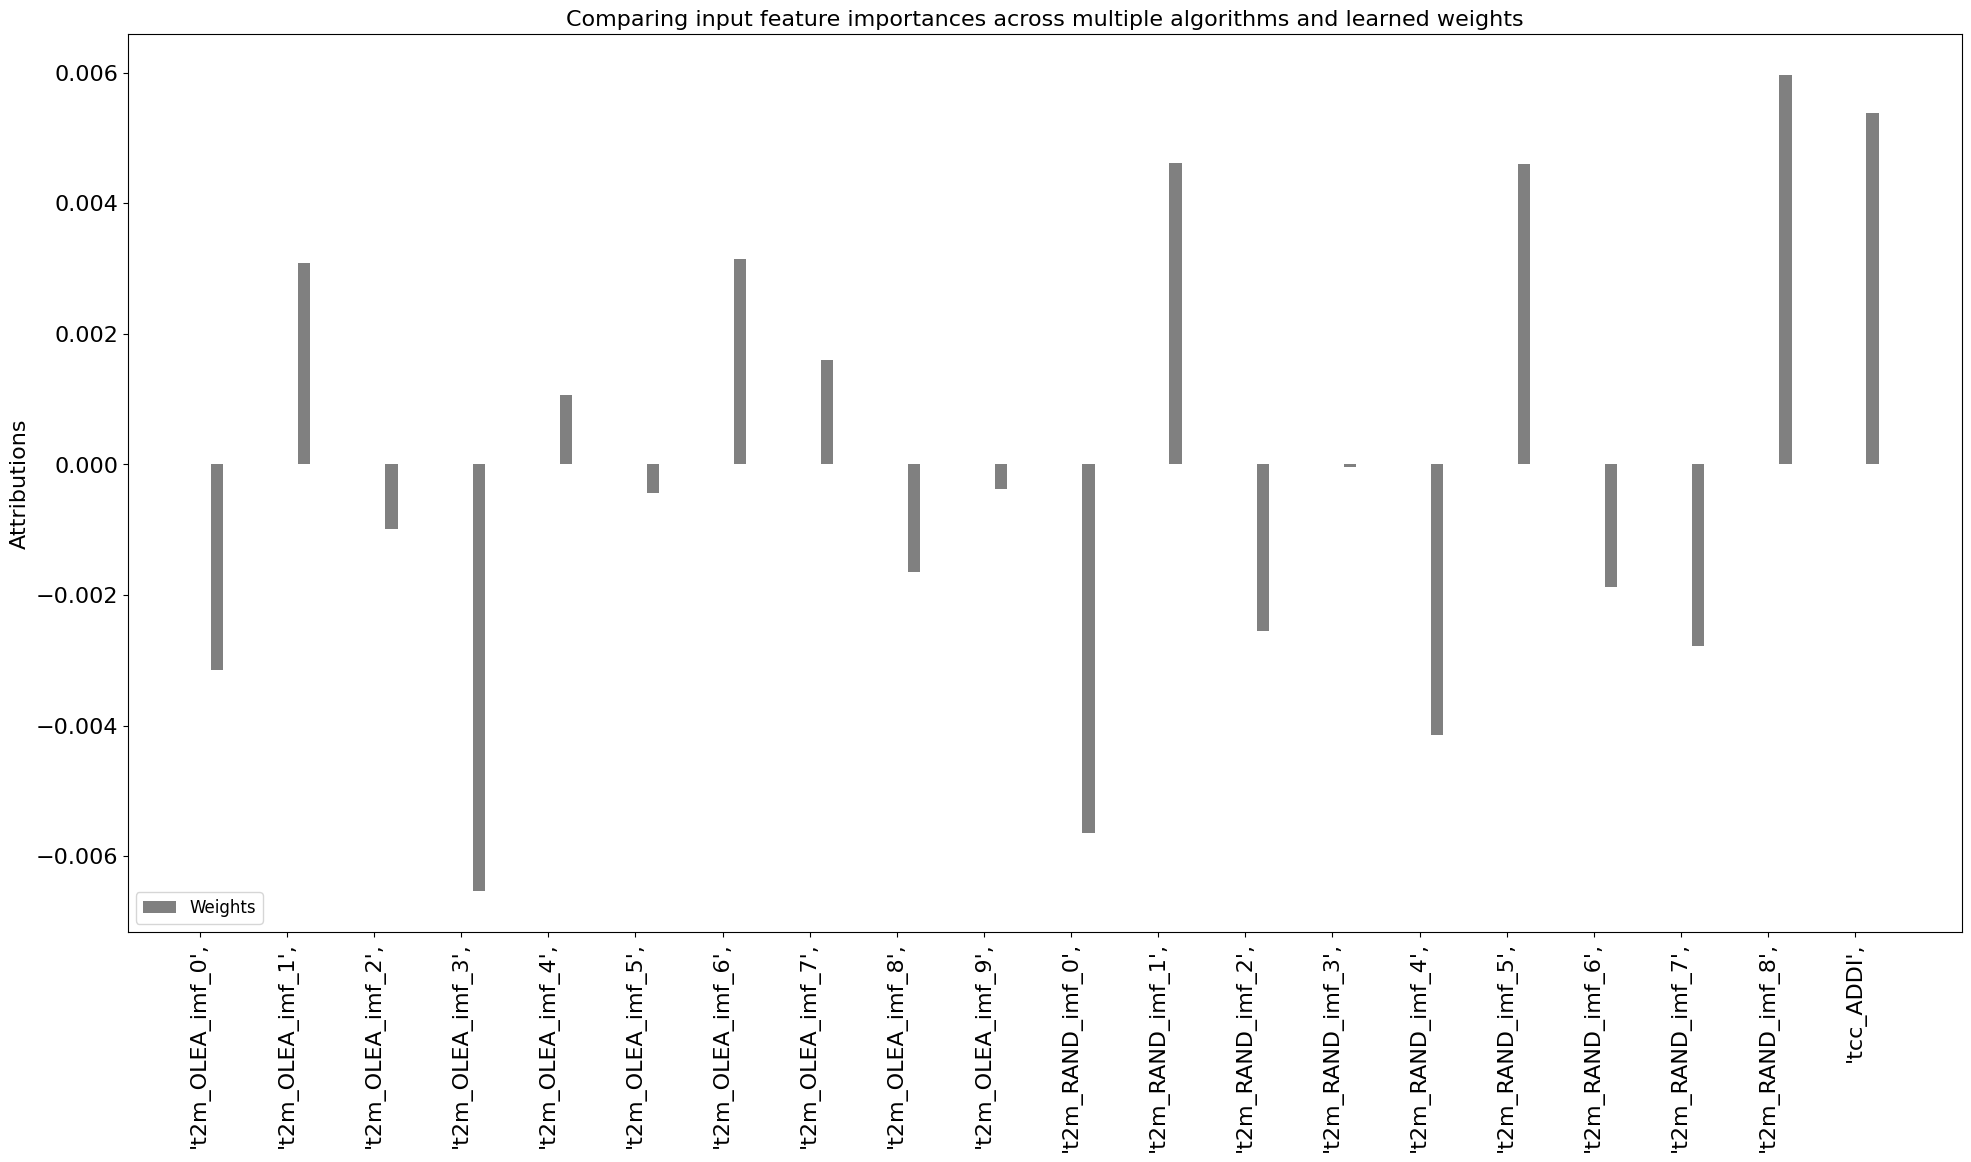

(443,)


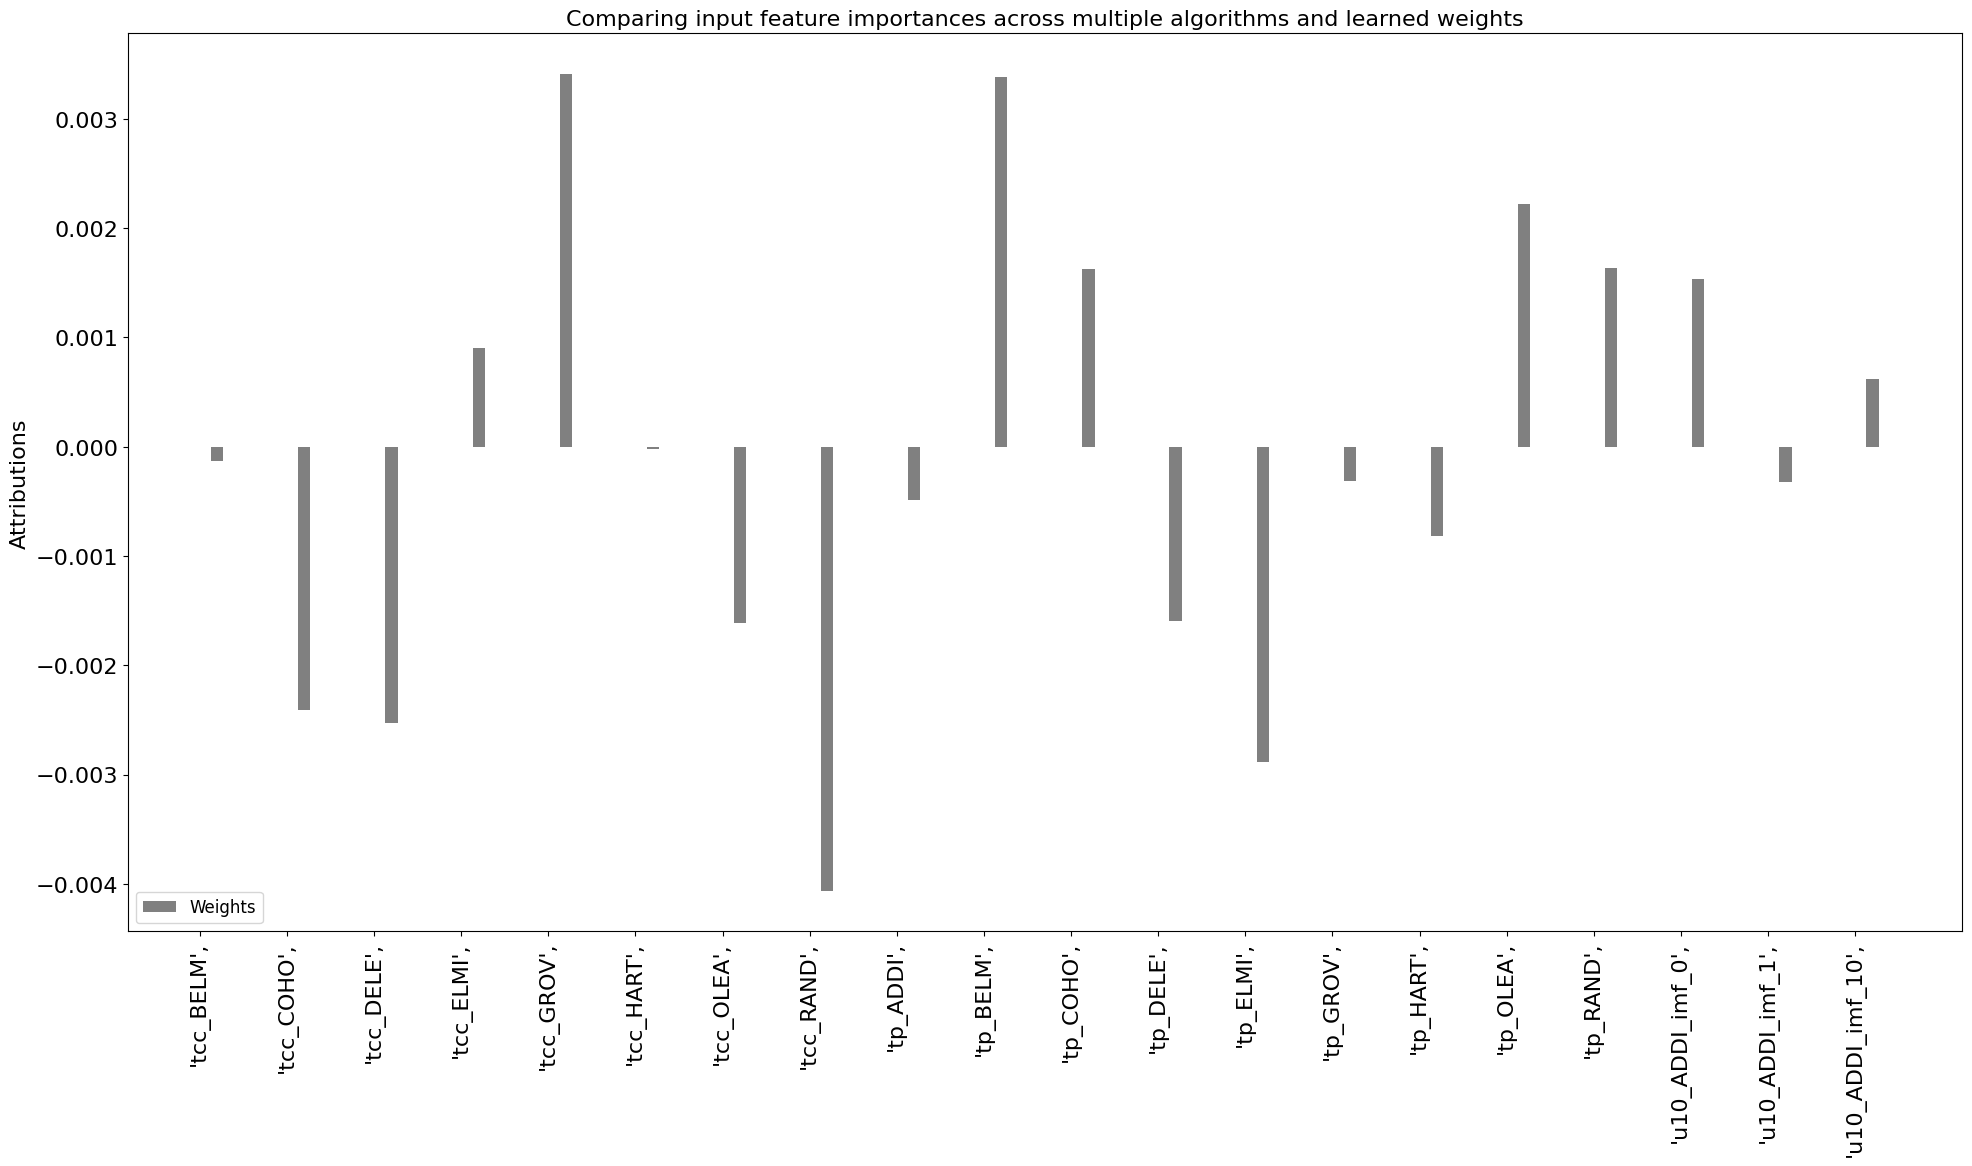

(443,)


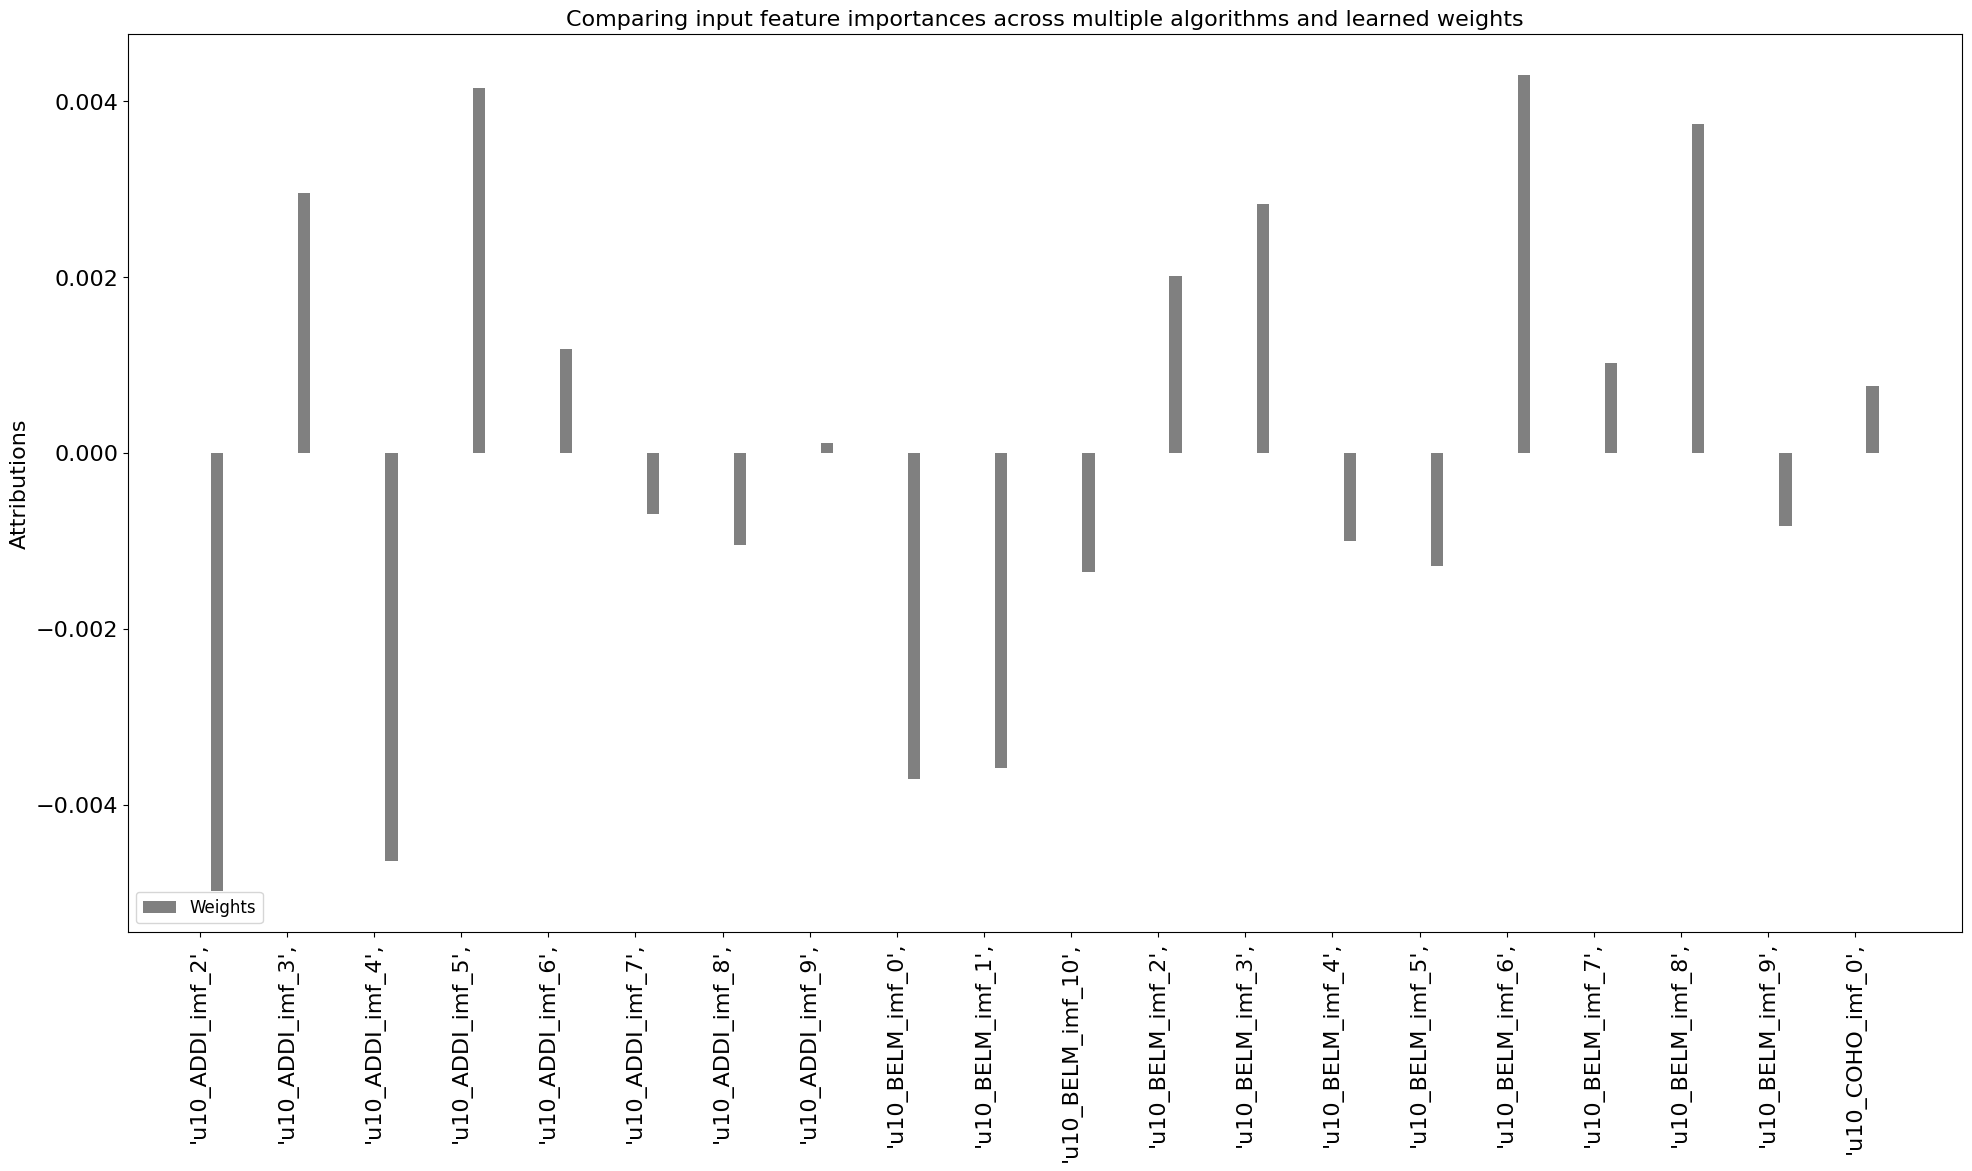

(443,)


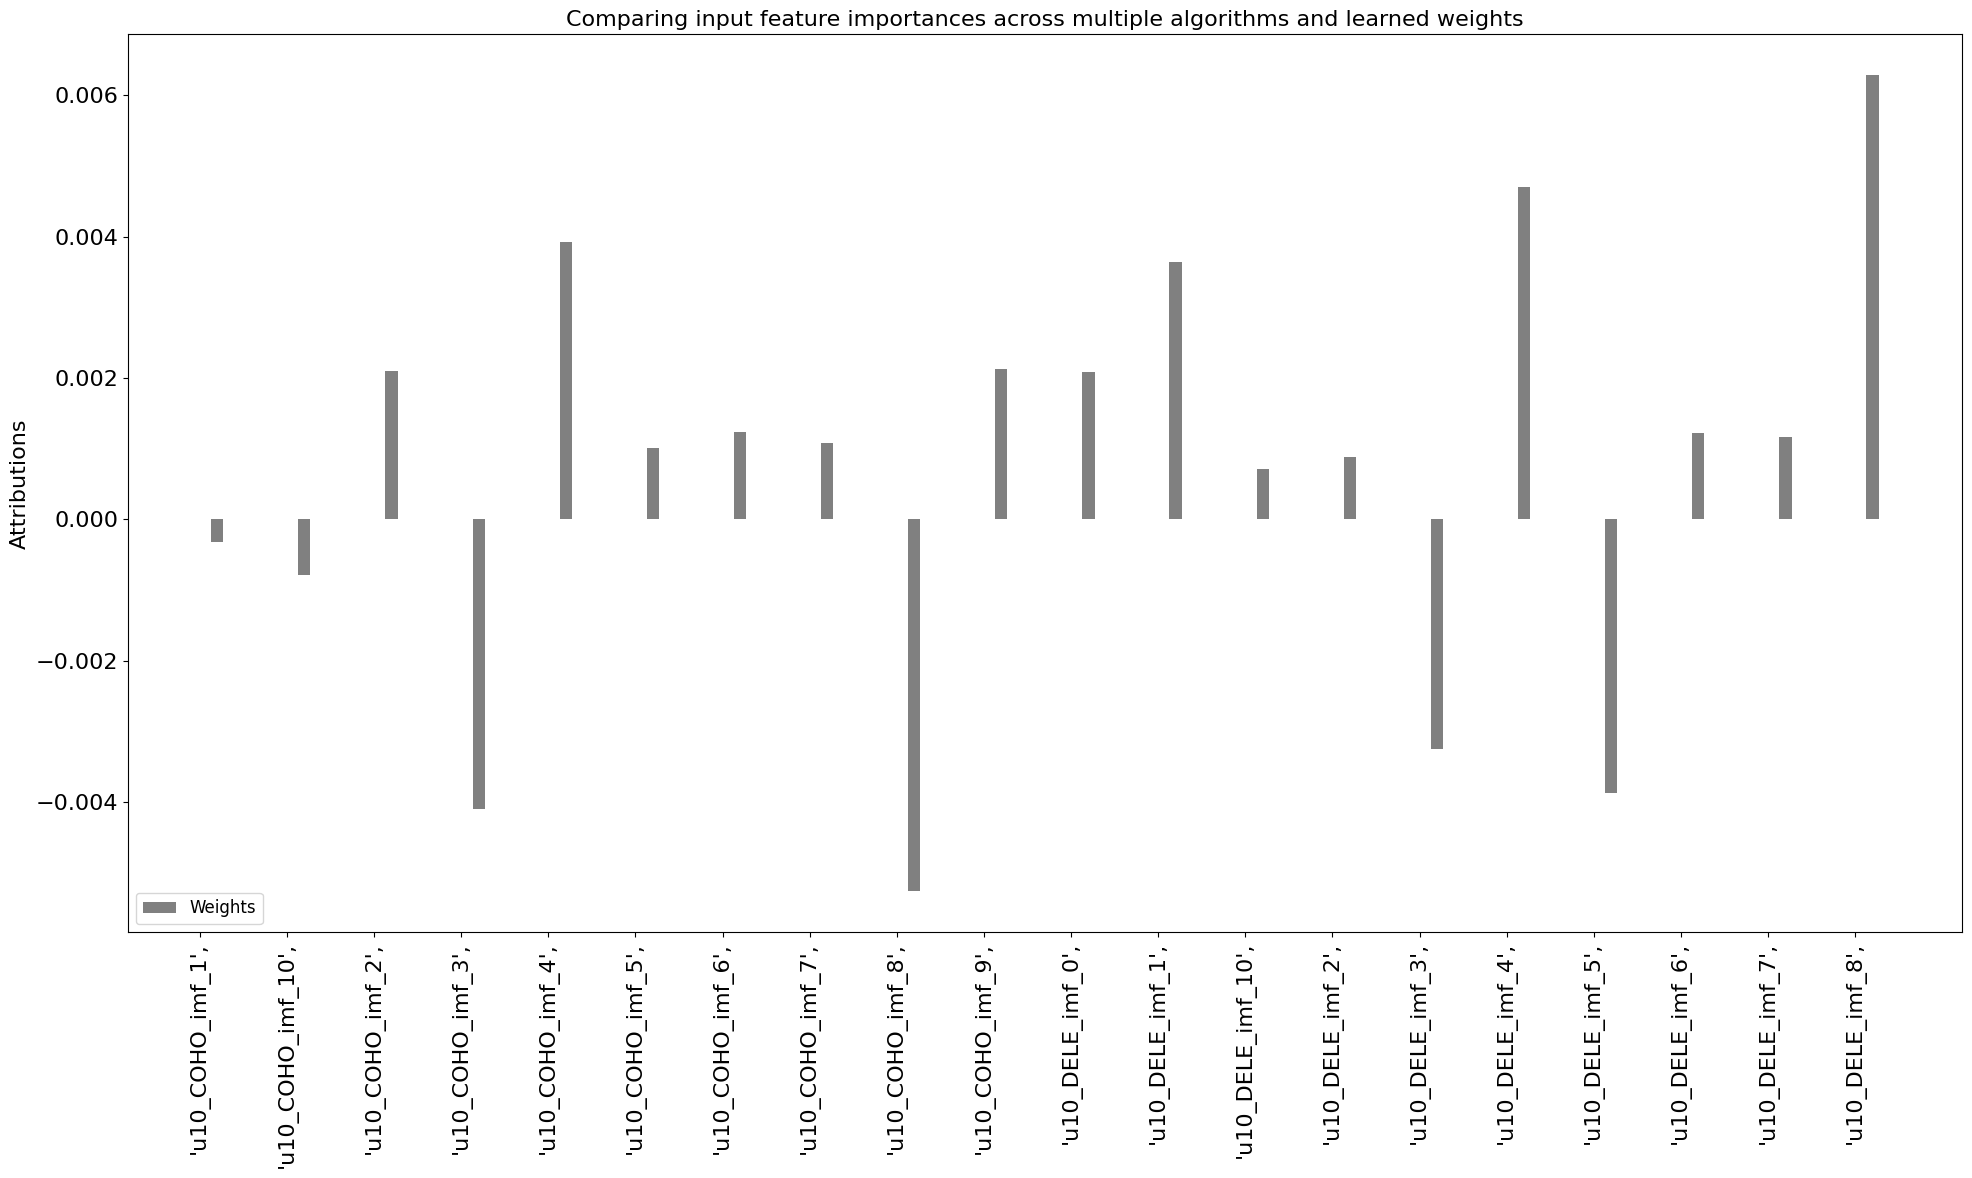

(443,)


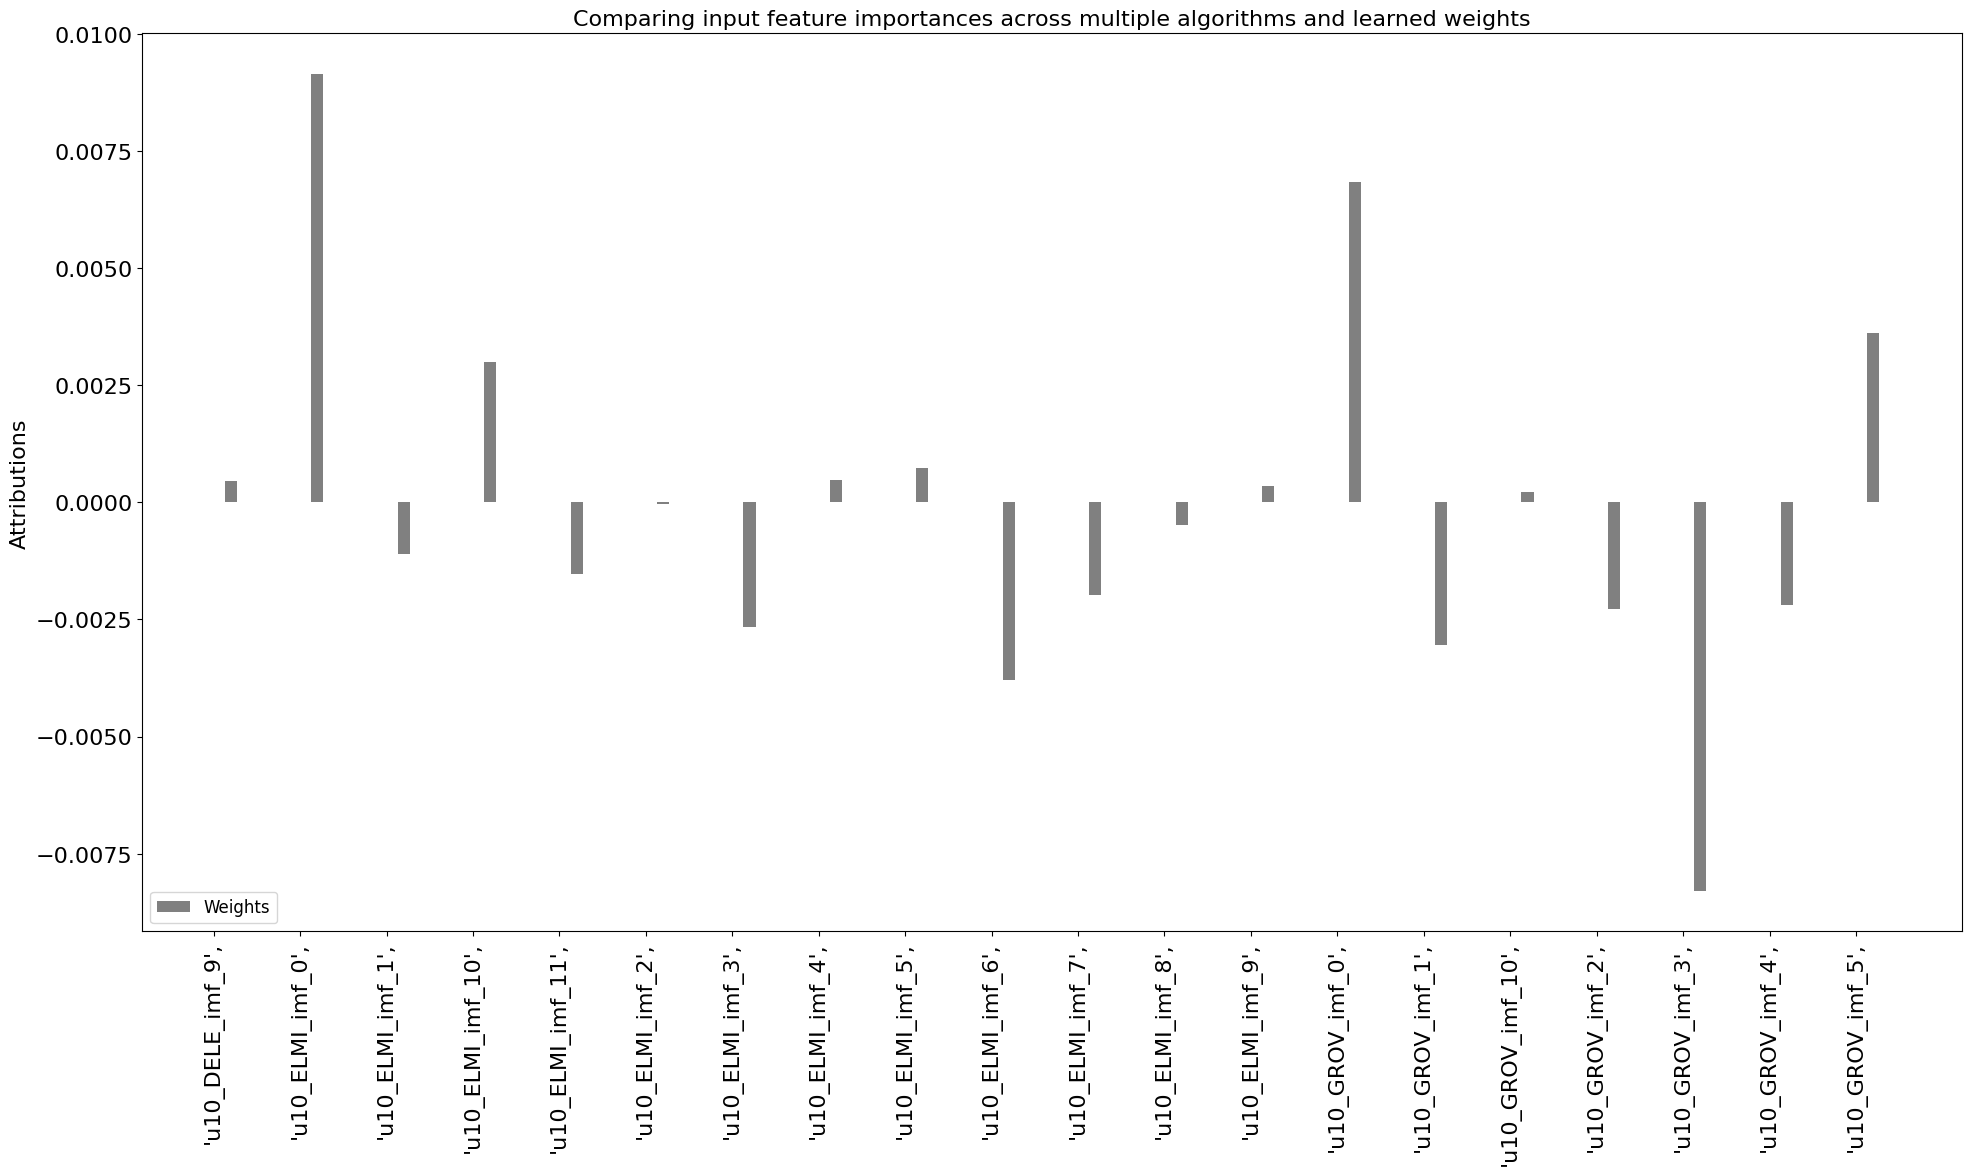

(443,)


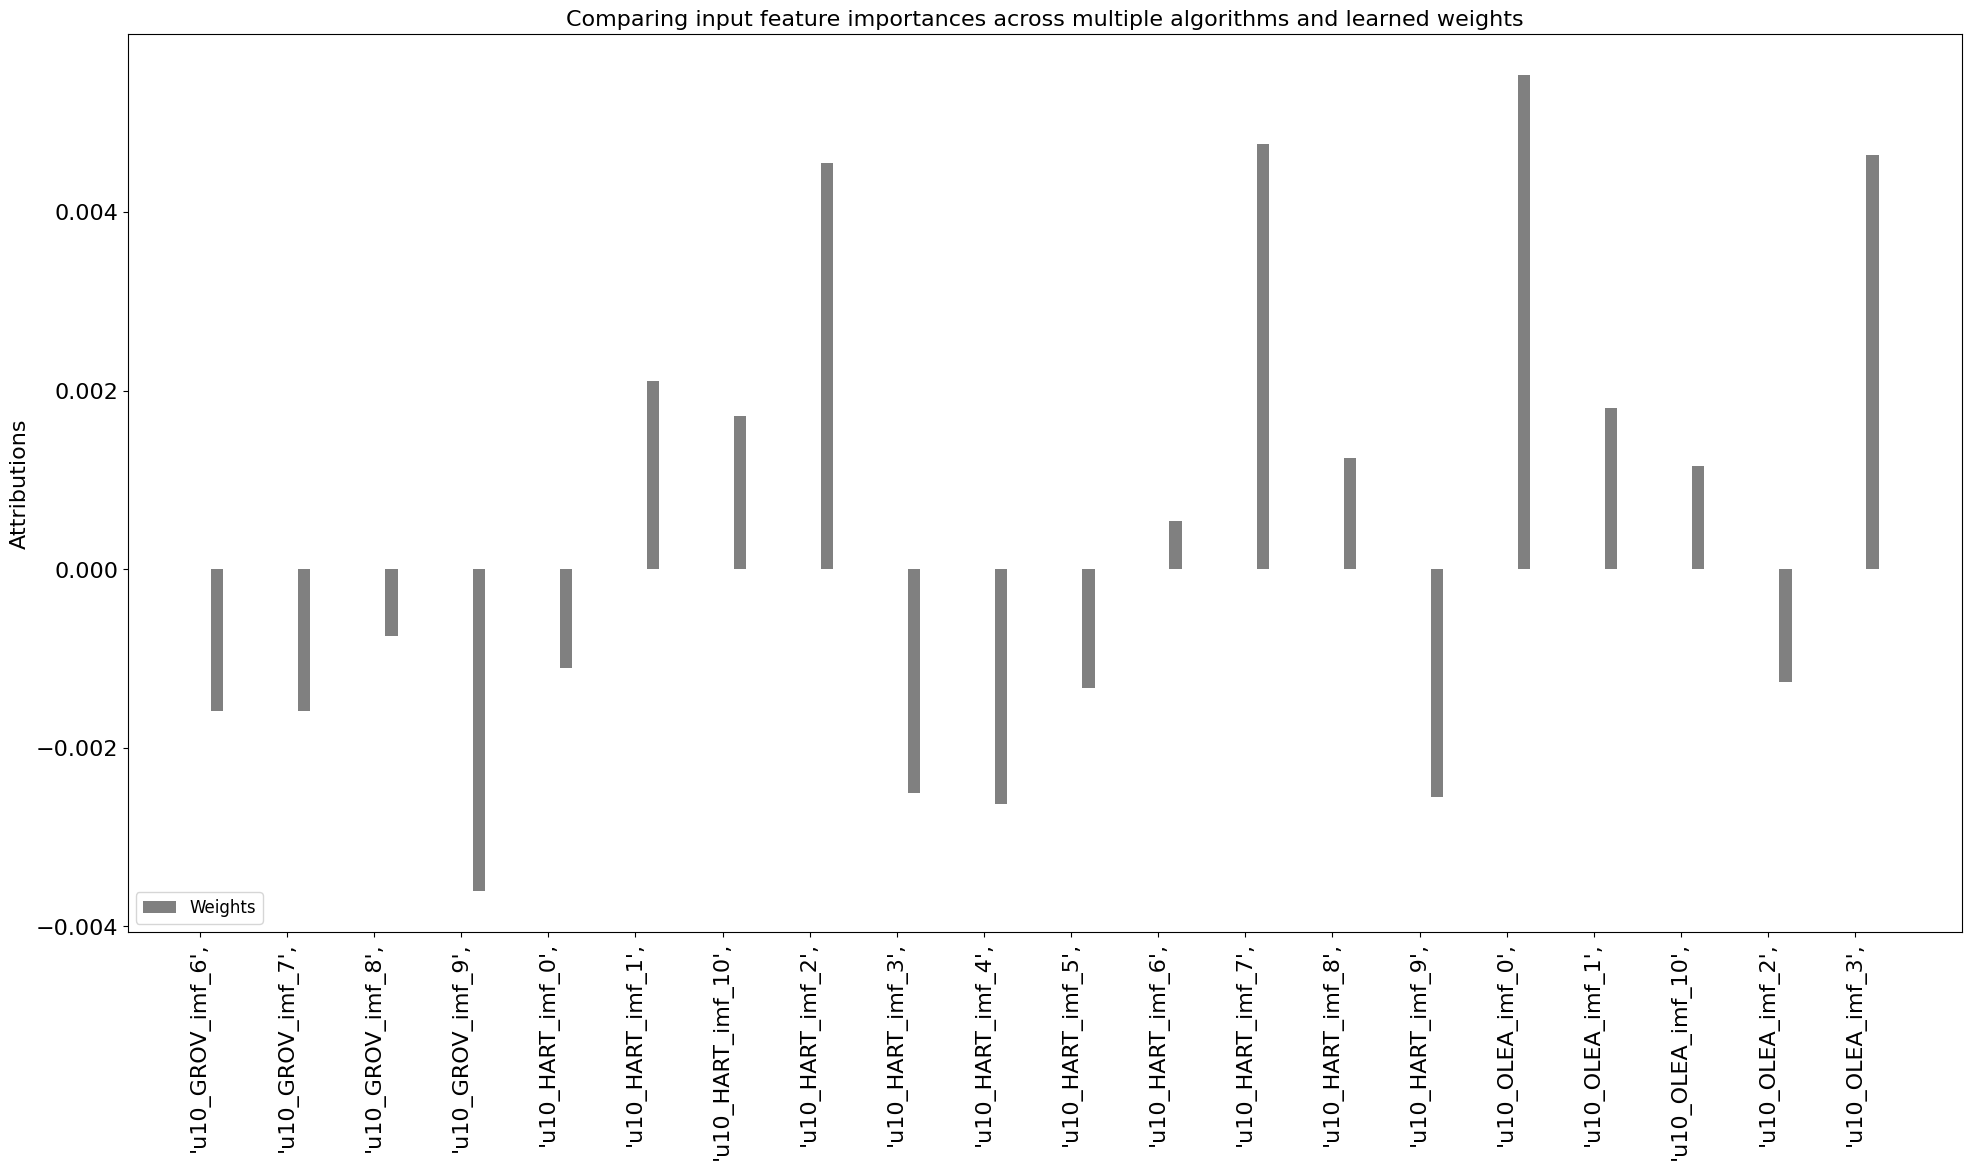

(443,)


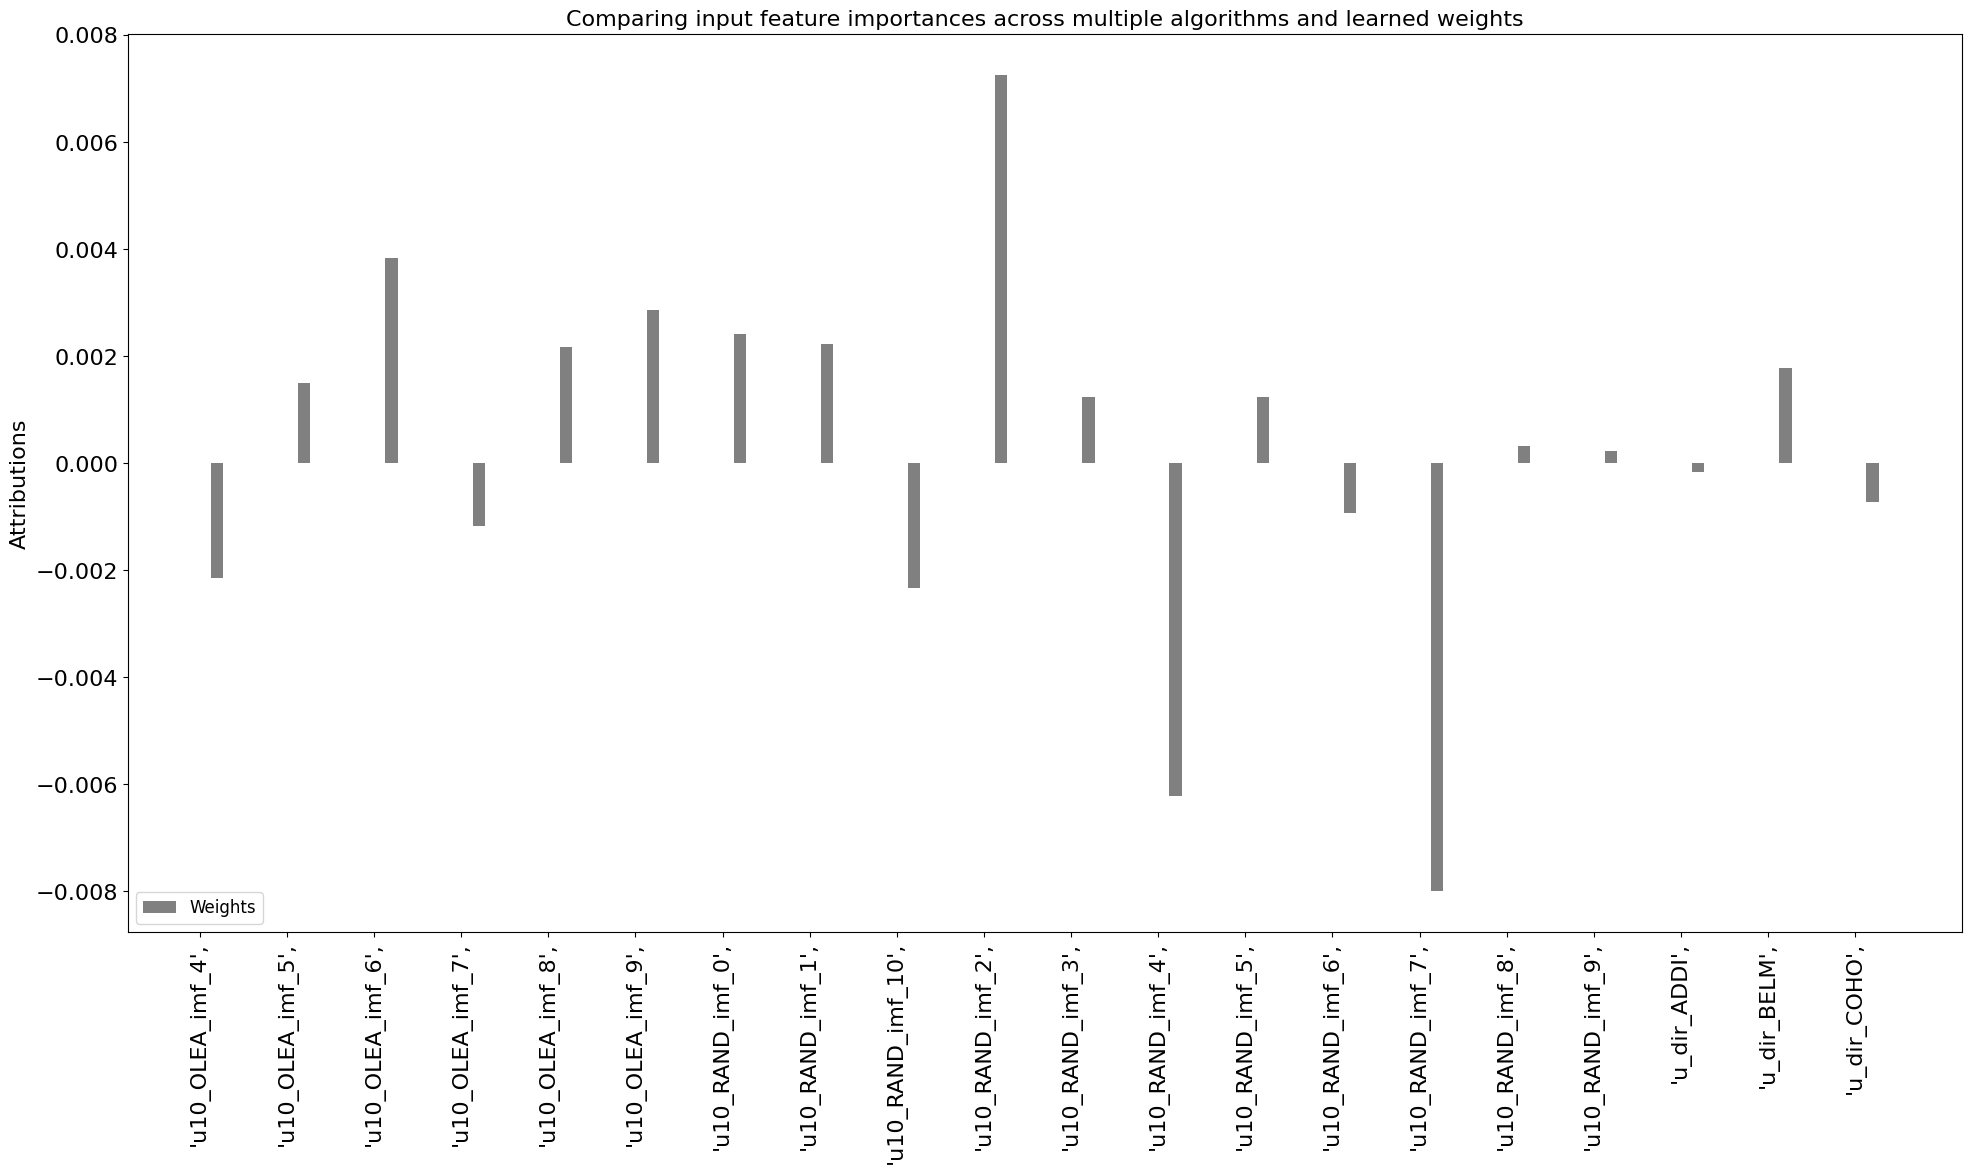

(443,)


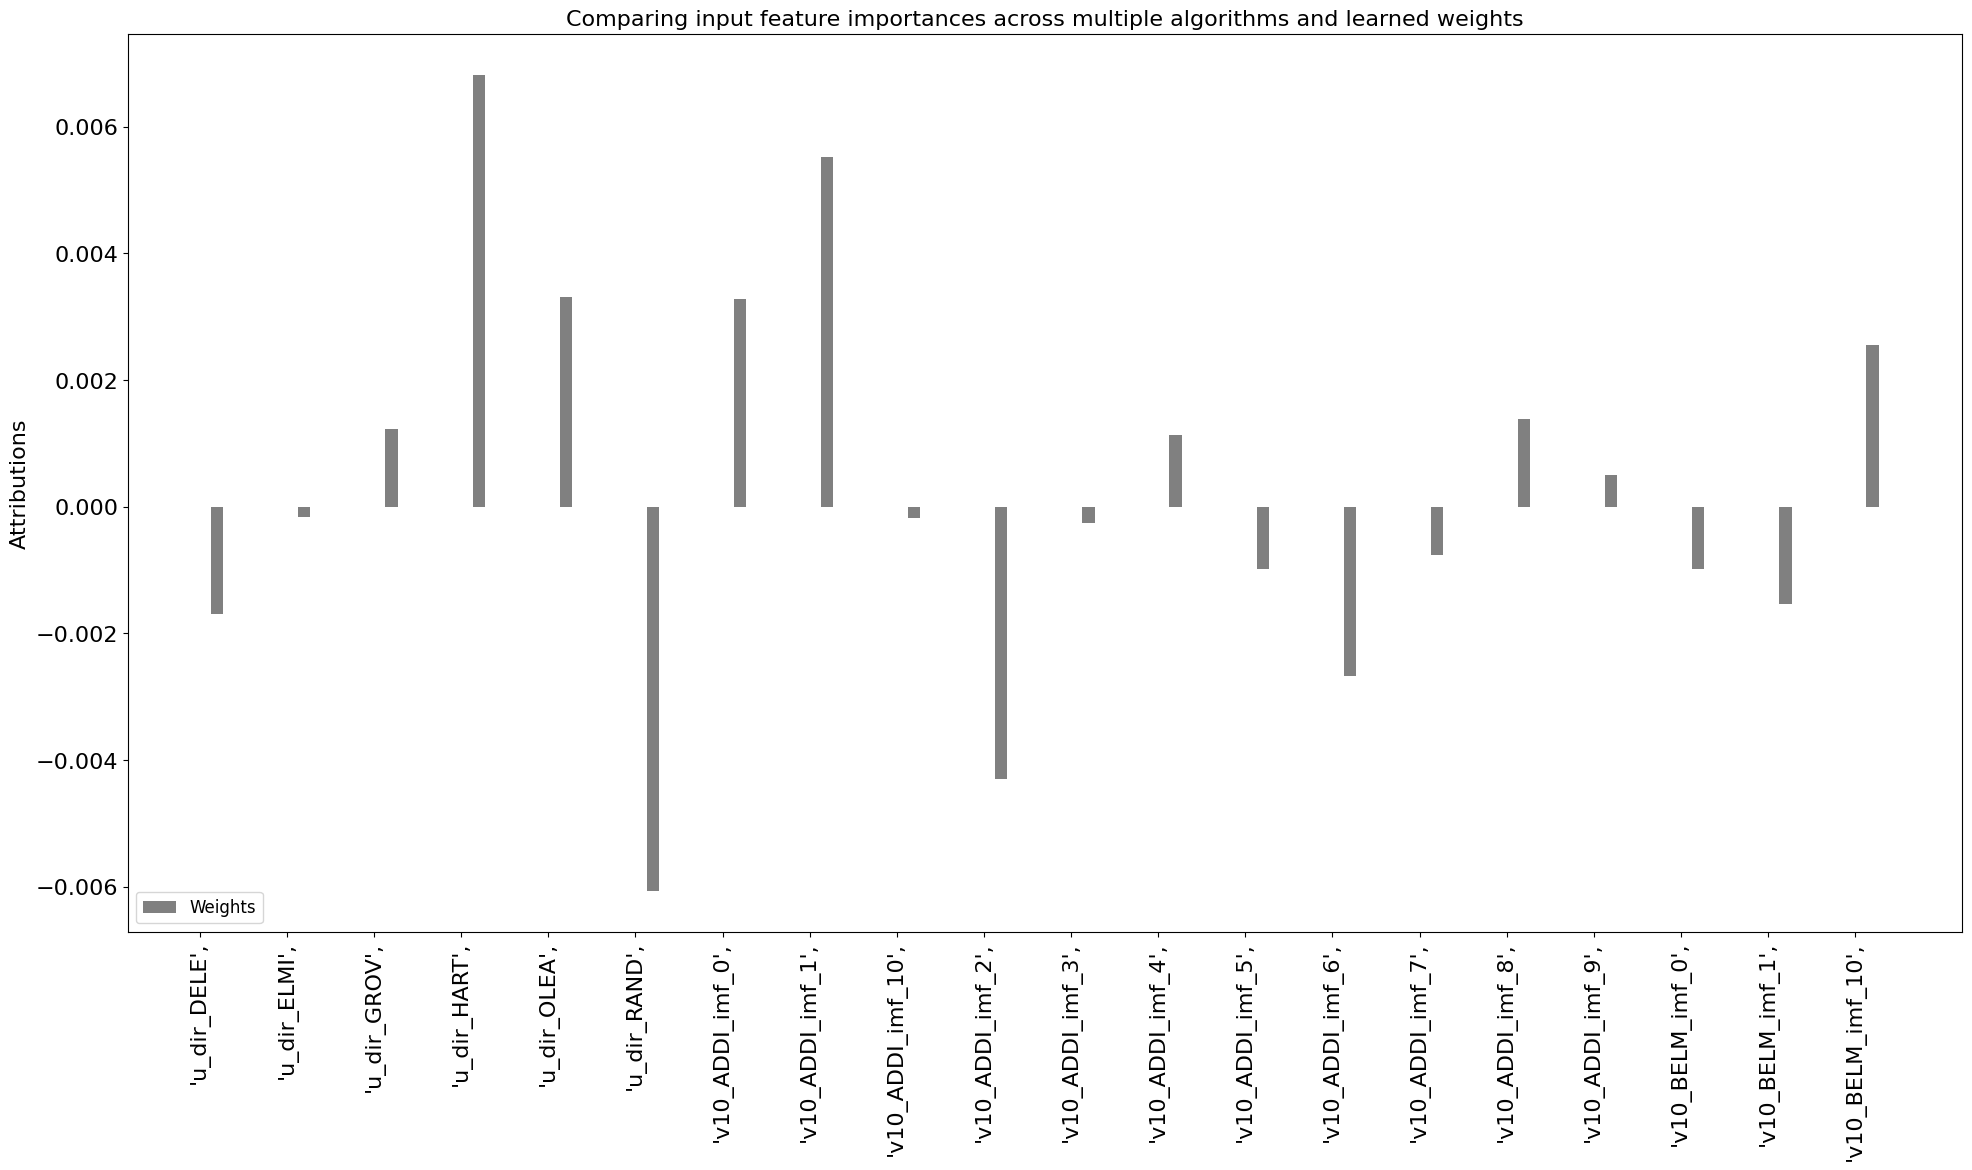

(443,)


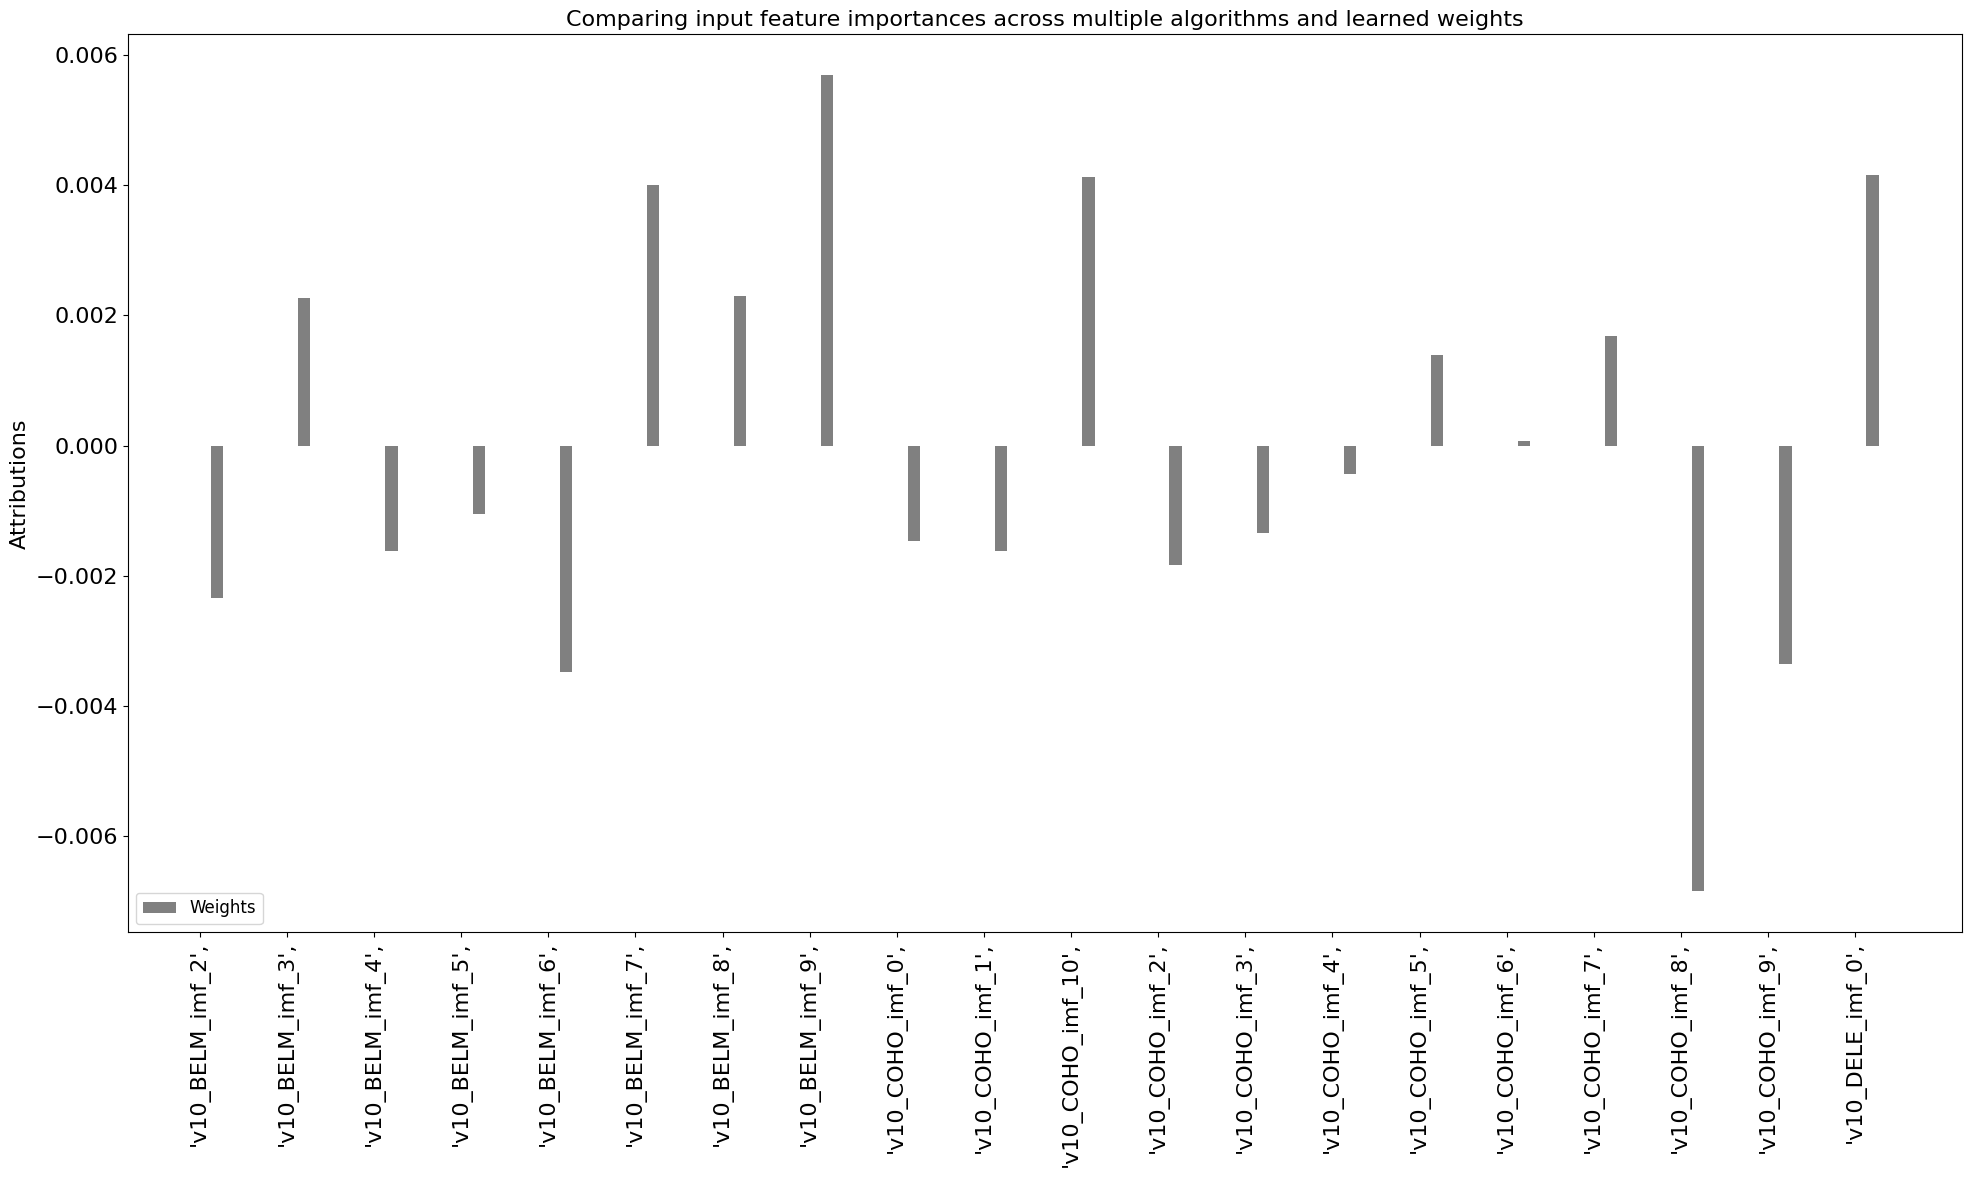

(443,)


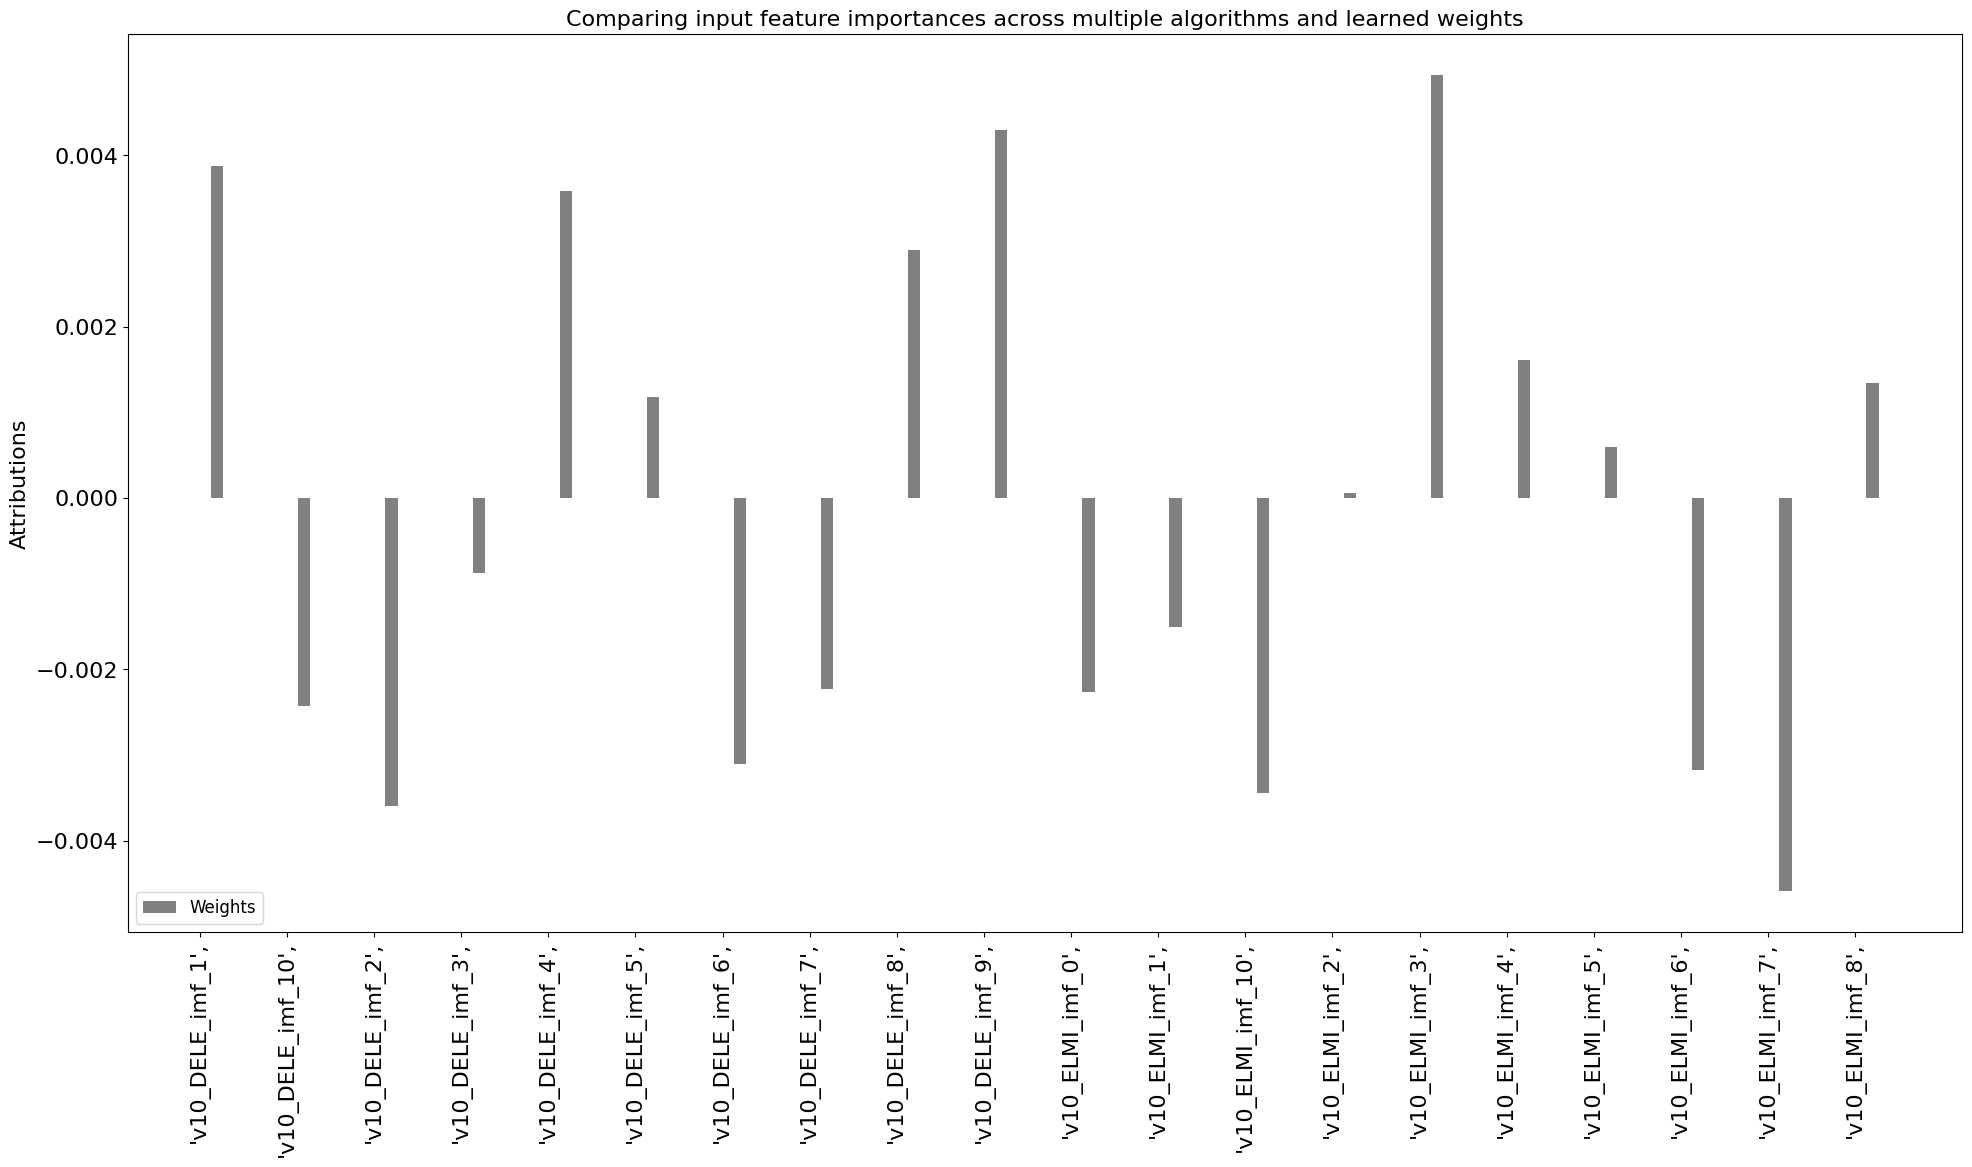

(443,)


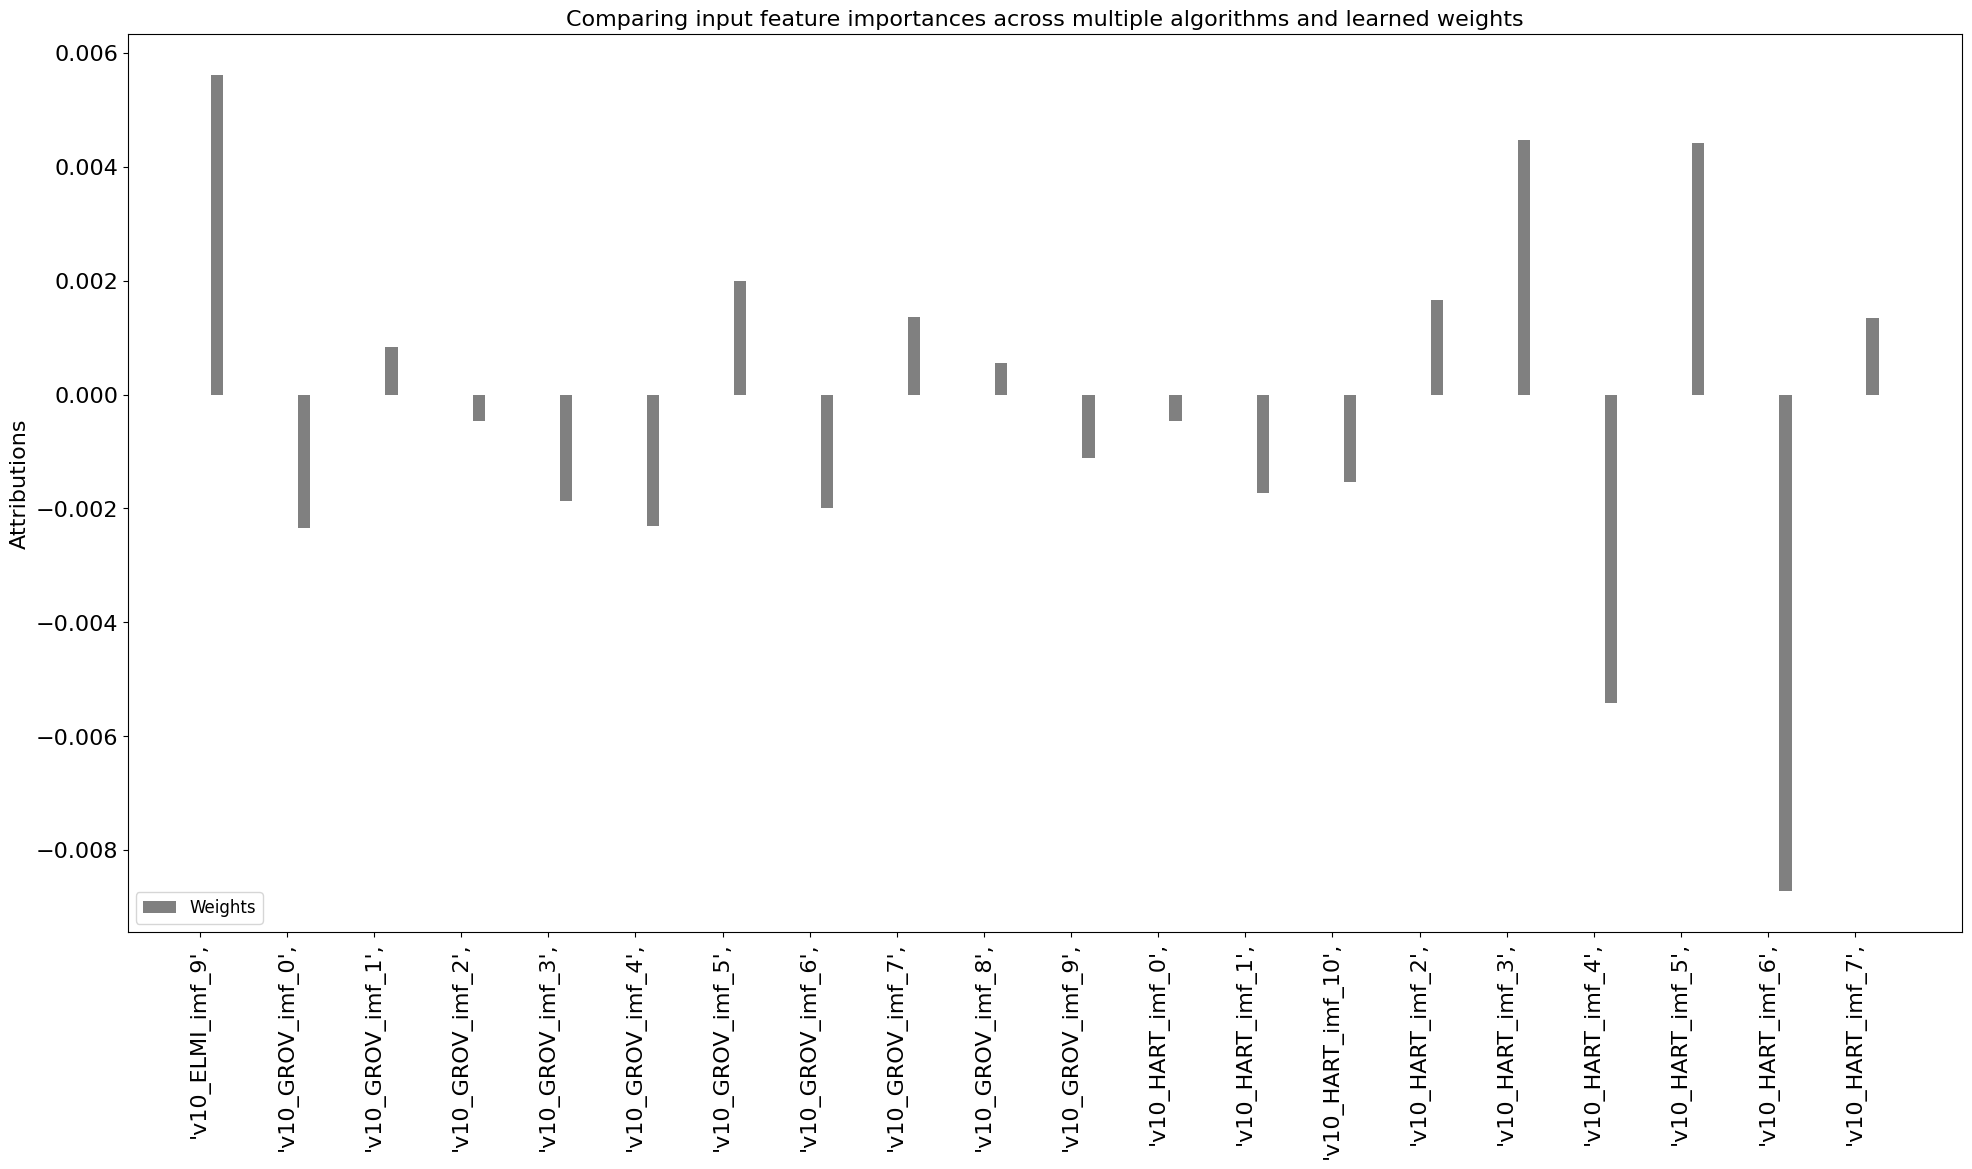

(443,)


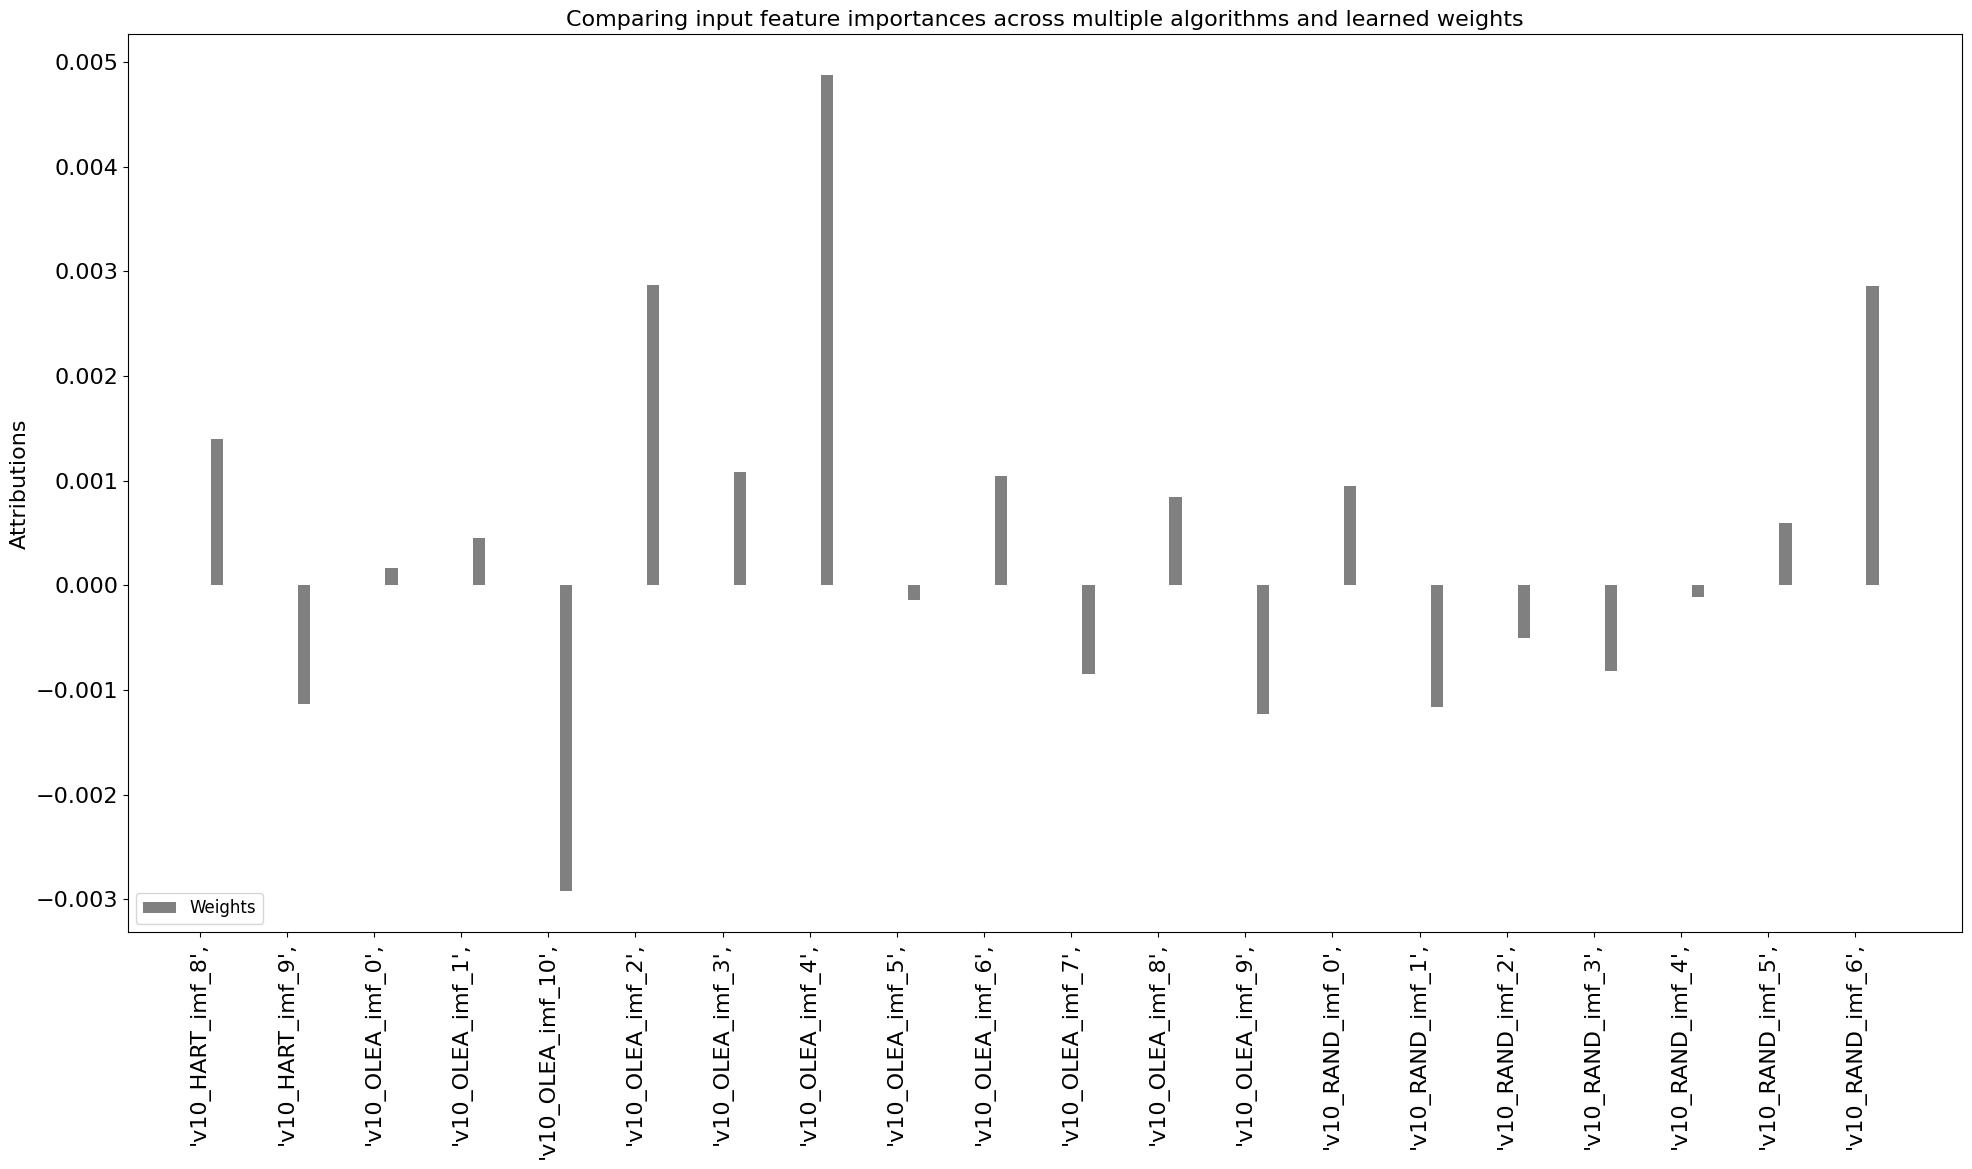

In [33]:
b = 0
e = 20
n = 10
# prepare attributions for visualization

x_axis_data = np.arange(features.shape[0])
x_axis_data_labels = list(map(lambda idx: features[idx], x_axis_data))

while e < len(x_axis_data):
    # ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
    # ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(
    #     ig_nt_attr_test_sum, ord=1
    # )

    lin_weight = model.linear.weight[0].detach().numpy()
    y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

    width = 0.14
    legends = ["Weights"]

    plt.figure(figsize=(20, 10))

    ax = plt.subplot()
    ax.set_title(
        "Comparing input feature importances across multiple algorithms and learned weights"
    )
    ax.set_ylabel("Attributions")

    FONT_SIZE = 16
    plt.rc("font", size=FONT_SIZE)  # fontsize of the text sizes
    plt.rc("axes", titlesize=FONT_SIZE)  # fontsize of the axes title
    plt.rc("axes", labelsize=FONT_SIZE)  # fontsize of the x and y labels
    plt.rc("legend", fontsize=FONT_SIZE - 4)  # fontsize of the legend

    print(x_axis_data.shape)

    # ax.bar(
    #     x_axis_data[b:e] + width,
    #     ig_nt_attr_test_norm_sum[b:e, n],
    #     width,
    #     align="center",
    #     alpha=0.7,
    #     color="#A90000",
    # )
    ax.bar(
        x_axis_data[b:e] + 5 * width,
        y_axis_lin_weight[b:e],
        width,
        align="center",
        alpha=1.0,
        color="grey",
    )
    ax.autoscale_view()
    plt.tight_layout()

    ax.set_xticks(x_axis_data[b:e] + 0.5)
    ax.set_xticklabels(x_axis_data_labels[b:e], rotation=90)

    plt.legend(legends, loc=3)
    plt.show()

    b += 20
    e += 20